# Sprint 機械学習スクラッチ SVM

In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# 評価
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# 可視化
import matplotlib.pyplot as plt
import japanize_matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [75]:
# データ
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

# trainとtestに分ける
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

# 【問題1】ラグランジュの未定乗数法による最急降下
### １．カーネル関数

In [76]:
# カーネル関数
def kernel(X,i,j):
    k = np.dot(X[i].T,X[j])
    return k

### ２．最急降下法

In [77]:
# 仮のパラメータ
# lamdaの初期値
lamda = np.ones(len(X))
# 学習率
lr = 0.001
# イテレーション
iter = 3

# ラグランジェ乗数　最急降下法
# イテレーション回数分回す．
for num in range(iter):
    # イテレーションごとにλを初期化
    lamda_old = np.zeros(lamda.shape)
    for i in range(len(X)):
        # 更新ごとにsigma内を初期化
        sigma = 0
        for j in range(len(X)):
            sigma += lamda[j]*y[i]*y[j]*kernel(X,i,j)
        
        lamda_old[i] = lamda[i] + lr*(1-sigma)
        # λが０以下なら0にする
        if lamda_old[i] < 0:
            lamda_old[i] = 0
    # 初期化前に求めたλをコピーしとく
    lamda = lamda_old.copy()
            
lamda

array([0.00000000e+00, 3.92920117e-04, 1.40881185e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.54333873e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.24764291e-04, 3.05609712e-04, 0.00000000e+00,
       1.65581863e-04, 6.16290798e-04, 0.00000000e+00, 3.48044304e-04,
       0.00000000e+00, 1.94980639e-04, 0.00000000e+00, 5.12242822e-04,
       0.00000000e+00, 0.00000000e+00, 5.41665628e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.87680601e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.73401439e-05,
       0.00000000e+00, 9.01241328e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.19745288e-04, 1.36116974e-04, 0.00000000e+00,
       2.29513497e-04, 9.00125214e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.57165215e-04, 0.00000000e+00, 6.34794665e-04,
      

# 【問題2】サポートベクターの決定
#### メモ：np.where
np.where(X < 0.5, 0, 1))・・・Xが0.5以下なら０，以上なら１                                
np.where(lamda > 0.5)・・・・lamdaが0.5以下のインデックスを取得

In [78]:
# 閾値
threshold = 1e-3

# サポートベクターのインデックスを取得
sv_index = np.where(lamda > threshold)

# sv_indexの特徴量
sv = X[sv_index]
# sv_indexのラグランジュ乗数
lamda_sv = lamda[sv_index]
# sv_indexのｙ
y_sv = y[sv_index]


print('サポートベクターの数：',sv.shape[0])
print('sv_shape:',sv.shape)
print('lamda_sv_shape:',lamda_sv.shape)
print('y_sv_shape:',y_sv.shape)
print('X_shape:',X.shape)
print('\nSV_index:\n',sv_index)
print('\nサポートベクター:\n',sv)

サポートベクターの数： 4
sv_shape: (4, 2)
lamda_sv_shape: (4,)
y_sv_shape: (4,)
X_shape: (500, 2)

SV_index:
 (array([121, 123, 162, 326], dtype=int64),)

サポートベクター:
 [[-1.02829008  0.23898594]
 [-0.97854994  0.34188908]
 [-0.50179779  0.74466058]
 [ 0.67098941 -0.58384118]]


# 【問題3】推定
メモ：np.sign()・・・各要素について，正の場合1，負の場合-1，0の場合は0を返す

In [79]:
def predict(X):
    y_pred = [np.sum([lamda_j * y_j * np.dot(x_j, x)
                      for (x_j, y_j, lamda_j) in zip(
                        sv, y_sv, lamda_sv)])
                   for x in X]
    return np.array(np.sign(y_pred))

# 【問題4】学習と推定
## １．スクラッチSVM

In [80]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """

    def __init__(self, num_iter, lr, threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        #self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
    
    
    # カーネル関数
    def _kernel(self,X,i,j):
        k = np.dot(X[i].T,X[j])
        return k
    
    # ラグランジェ乗数　最急降下法
    def _gradient_descent(self,X,y,lamda):
        lamda_old = np.zeros(lamda.shape)
        for i in range(len(X)):
            sigma = 0
            for j in range(len(X)):
                sigma += lamda[j]*y[i]*y[j]*self._kernel(X,i,j)
            lamda_old[i] = lamda[i] + self.lr*(1-sigma)
            if lamda_old[i] < 0:
                lamda_old[i] = 0
        lamda = lamda_old.copy()
        return lamda
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証用データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """

        # λの初期化
        lamda = np.zeros(len(X))
        # イテレーションの数だけ学習
        for num in range(self.iter):
            lamda = self._gradient_descent(X,y,lamda)

            # 学習過程の出力
            if self.verbose is True:
                map_result_lamda = map(str, lamda)
                result_lamda = ',\n'.join(map_result_lamda)
                print('\nTrain Data λ学習{0}回目 : \n{1}'.format(num,result_lamda))
            else:
                pass
        
        # サポートベクター
        self.index_support_vectors = np.where(lamda > self.threshold)
        self.X_sv = X[self.index_support_vectors]
        self.n_support_vectors = self.X_sv.shape[0]
        self.lam_sv = lamda[self.index_support_vectors]
        self.y_sv = y[self.index_support_vectors]
        
        
        # テストデータがある場合
        if X_val is not None:
            #カーネル関数が線形なら
            #if self.kernel == linear:
            # λの初期化
            lamda_val = np.zeros(len(X_val))
            # イテレーションの数だけ学習
            for num in range(self.iter):
                lamda_val =  self._gradient_descent(X_val,y_val,lamda_val)
                
                # 学習過程の出力
                if self.verbose is True:
                    map_result_lamda_val = map(str, lamda_val)
                    result_lamda_val = ',\n'.join(map_result_lamda_val)
                    print('\nTest Data λ 学習{0}回目 : \n{1}'.format(num,result_lamda_val))
                else:
                    pass

            # サポートベクター
            self.index_support_vectors_val = np.where(lamda_val > self.threshold)
            self.X_sv_val = X_val[self.index_support_vectors_val]
            self.lam_sv_val = lamda_val[self.index_support_vectors_val]
            self.y_sv_val = y_val[self.index_support_vectors_val]
    
    
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        step1 = X@self.X_sv.T
        y_pred = (self.lam_sv*self.y_sv)@step1.T
        return np.sign(y_pred)

In [81]:
# 初期化，学習，推定
scratch_svm = ScratchSVMClassifier(num_iter=100, lr=0.001, threshold=1e-5, verbose=True)
scratch_svm.fit(X_train,y_train)
y_pred = scratch_svm.predict(X_test)


Train Data λ学習0回目 : 
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001


Train Data λ学習2回目 : 
0.0014847264490188703,
0.0013260974400248616,
0.0010326518084680168,
0.0009453171885680357,
0.00036231672574796157,
0.0011209899270791164,
0.0004331515326329901,
0.0010274652857676621,
0.0016258055558970581,
0.0008019705732539423,
0.0004906472048083284,
0.0009182387835188974,
0.0008998233917798304,
0.001007931658374964,
0.0007866629974320416,
0.0006134123092624232,
0.0009730923652323967,
0.0015299221992398017,
0.00104235741488785,
0.0010041841242259455,
0.0008201446785650346,
0.0014496259477474382,
0.0008802342914230432,
0.0004651143645726644,
0.0008263190457035104,
0.0010922082421366557,
0.0005535524380879994,
0.0008455234001207058,
0.0013118644423411562,
0.00046431654977423134,
0.000618051560382875,
0.0008181734623563198,
0.000669018117000002,
0.001521236098808042,
0.0012926293023171986,
0.0007703983773432249,
0.00043370351148686585,
0.0014060156342768646,
0.0006048070330237281,
0.0012211716260423053,
0.0006652540532865224,
0.0010631146112783313,
0.0004550703339


Train Data λ学習3回目 : 
0.001551422538563497,
0.0012917235579550752,
0.0008257946976778757,
0.000684093861509434,
0.0,
0.0009599657851340931,
0.0,
0.0008154872510684531,
0.0017800746821248561,
0.0004484455001420759,
0.0,
0.0006367619692577544,
0.0006026262806435556,
0.0007810472583119528,
0.0004197266688912644,
0.0001502165111378845,
0.0007345743857701551,
0.0016307983226802201,
0.0008368472122669328,
0.0007755235031646471,
0.00047201767726658524,
0.0014974684649683456,
0.0005746168246314369,
0.0,
0.0004877464896370532,
0.0009231538089119853,
5.458502202878505e-05,
0.0005238792643997937,
0.00126896846135807,
0.0,
0.00015589658887344609,
0.00047024530503085983,
0.0002363322608994047,
0.0016068874798249963,
0.0012431282386117935,
0.000402466894039701,
0.0,
0.0014195877664571134,
0.00012488080943410992,
0.0011248143867877457,
0.00023304579645014702,
0.000866238395731724,
0.0,
0.0020640483095475393,
0.0,
0.0011394788944502807,
0.0,
0.0,
0.000557520138334286,
5.93137822540922e-05,
0.0,
0.0003


Train Data λ学習5回目 : 
0.0022234013355436006,
0.0018457567368510399,
0.0010709122838579662,
0.0008562655161175297,
0.0,
0.0013362310226361113,
0.0,
0.0010681257538682212,
0.002571451361886697,
0.0005201035009306072,
0.0,
0.0008075949719385071,
0.0007847406089874291,
0.0010345744872654321,
0.0005029165459166068,
1.6102363756163065e-05,
0.0008960255647934052,
0.002302659058297689,
0.001119479203995466,
0.0010224339491366953,
0.0005959084572855423,
0.002121359199331601,
0.0007167300982048362,
0.0,
0.0005810225584064301,
0.0012134524183624307,
0.0,
0.0006020418925301717,
0.0018089963493838053,
0.0,
3.722742969480578e-05,
0.0005835578424591769,
0.00017437522490542886,
0.002332988802204773,
0.0017334603687037666,
0.0004148854040688588,
0.0,
0.0020516687536173374,
5.4821226105343333e-05,
0.0015703284788261542,
0.0001502762122838937,
0.0011930636448440025,
0.0,
0.003016603535855689,
0.0,
0.0015394794522280287,
0.0,
0.0,
0.0006945978218630438,
0.0,
0.0,
0.0003773329376985998,
0.00014960039670469


Train Data λ学習7回目 : 
0.0027271340019054246,
0.002199572170173535,
0.001118466413727783,
0.0008187272046032597,
0.0,
0.001488147171452276,
0.0,
0.0011144061317000175,
0.0032131392543997823,
0.00034902631885658296,
0.0,
0.0007504586438917311,
0.0007181637674651272,
0.0010673087081814526,
0.00032467903745880475,
0.0,
0.0008747332122626892,
0.002838352071717759,
0.001185867207041151,
0.001050405034133283,
0.000454354065314514,
0.002584907060292966,
0.0006235290684014158,
0.0,
0.0004340772495098223,
0.0013175788464316461,
0.0,
0.00046387370394053993,
0.002148269061579949,
0.0,
0.0,
0.000437234711019631,
0.0,
0.0028798281760010406,
0.0020432680866651195,
0.00020256549078821447,
0.0,
0.002486952761430168,
0.0,
0.0018152537232439877,
0.0,
0.0012882396242425167,
0.0,
0.0038345655236732743,
0.0,
0.001772874690615385,
0.0,
0.0,
0.0005925732530662147,
0.0,
0.0,
0.00014940055847740888,
0.0,
0.003300458281886941,
0.0,
0.0,
0.00025091992225961265,
0.0010723864964809037,
0.0,
0.001679170176908078,
0.


Train Data λ学習9回目 : 
0.0031690162267481578,
0.002478406381299122,
0.0010953953454084133,
0.0007058634337857092,
0.0,
0.0015560807335328686,
0.0,
0.0010860397944229836,
0.003800076244499805,
8.884172048040926e-05,
0.0,
0.0006098211689479947,
0.0005586763395873243,
0.0010189129984560018,
4.883240665514208e-05,
0.0,
0.0007903198211402767,
0.0033265831604933184,
0.0011728672881569356,
0.0009981453617723547,
0.000212971480045932,
0.0029906419001128636,
0.0004438269400859324,
0.0,
0.00019893044925375328,
0.0013557261277647894,
0.0,
0.000248373918088396,
0.002412463028749312,
0.0,
0.0,
0.00019379737281287183,
0.0,
0.0033593218535331805,
0.0022875798953781454,
0.0,
0.0,
0.0028479899931664722,
0.0,
0.001986143336724296,
0.0,
0.0012966654821049666,
0.0,
0.004602895377361578,
0.0,
0.001947942452460843,
0.0,
0.0,
0.00040240027542933746,
0.0,
0.0,
0.0,
0.0,
0.0039019426747743773,
0.0,
0.0,
0.0,
0.0010225024734501302,
0.0,
0.0018219384659783038,
0.0031503285627348075,
0.000221788328404874,
0.0,
0.0


Train Data λ学習11回目 : 
0.0035674620192531576,
0.0027072737227302034,
0.0010188125149210399,
0.0005366460682552747,
0.0,
0.0015679803624077627,
0.0,
0.0010028778248217486,
0.0043480205026352374,
0.0,
0.0,
0.00040994713809072887,
0.0003368447473913808,
0.0009134675084383358,
0.0,
0.0,
0.0006536477208586627,
0.00377641098678695,
0.00110390478895551,
0.0008890419852282037,
0.0,
0.0033535640451260126,
0.00020336717056671674,
0.0,
0.0,
0.0013427288933969398,
0.0,
0.0,
0.0026264261754379964,
0.0,
0.0,
0.0,
0.0,
0.0037943442318857023,
0.0024841987978832724,
0.0,
0.0,
0.003160598113979963,
0.0,
0.002105616205882718,
0.0,
0.0012472776383839845,
0.0,
0.005336668661372922,
0.0,
0.0020763435031989123,
0.0,
0.0,
0.00015081056508480263,
0.0,
0.0,
0.0,
0.0,
0.004461717242158101,
0.0,
0.0,
0.0,
0.0009146979671509468,
0.0,
0.001915860600105752,
0.0035580927424200513,
0.0,
0.0,
0.0036996126467286655,
0.0,
0.0028677076632640072,
0.0,
0.0019779314801060916,
0.001244255678135677,
0.0050903361188707535,
0.00


Train Data λ学習13回目 : 
0.003920553191074616,
0.00288373926091343,
0.0008866868423068051,
0.0003088795747541504,
0.0,
0.0015211216079092814,
0.0,
0.0008627017353990773,
0.004855296085257078,
0.0,
0.0,
0.00014827112594199105,
4.9669292126796835e-05,
0.0007484591285084967,
0.0,
0.0,
0.00046308203576755837,
0.0041865699931715565,
0.0009765261673374583,
0.0007206269932174523,
0.0,
0.0036719705270658425,
0.0,
0.0,
0.0,
0.001276736599913514,
0.0,
0.0,
0.0027877284981303483,
0.0,
0.0,
0.0,
0.0,
0.004182691756623168,
0.002631162581627934,
0.0,
0.0,
0.003422323377754537,
0.0,
0.0021713527523852232,
0.0,
0.0011372591455785842,
0.0,
0.006034333942791933,
0.0,
0.0021565010596913837,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.004977626832846227,
0.0,
0.0,
0.0,
0.000746326027001548,
0.0,
0.001959116416235186,
0.003924780089600594,
0.0,
0.0,
0.004094291395245414,
0.0,
0.00309846940425265,
0.0,
0.0020253206341820625,
0.001144751754281685,
0.005757471405557458,
0.0019887112945789613,
0.0,
0.0,
0.0,
0.0,
0.000


Train Data λ学習15回目 : 
0.004242463115954909,
0.003023735761730175,
0.0007170194795811655,
4.142902475100783e-05,
0.0,
0.0014333818041399149,
0.0,
0.0006837189607358846,
0.005334701226786503,
0.0,
0.0,
0.0,
0.0,
0.000542513464888531,
0.0,
0.0,
0.0002367695850180723,
0.0045702913548383555,
0.0008090210741544912,
0.0005115174746256474,
0.0,
0.003960136511870977,
0.0,
0.0,
0.0,
0.0011751015985840788,
0.0,
0.0,
0.0029124158736252032,
0.0,
0.0,
0.0,
0.0,
0.004538485581394067,
0.002744267690725336,
0.0,
0.0,
0.00364845569530631,
0.0,
0.0022000506665644484,
0.0,
0.0009850454636362957,
0.0,
0.00670712578270343,
0.0,
0.0022044300262920448,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0054627718799836675,
0.0,
0.0,
0.0,
0.0005361411861482278,
0.0,
0.0019681926104722675,
0.00426401901411903,
0.0,
0.0,
0.004462130989459799,
0.0,
0.0032989635091920156,
0.0,
0.002036808463115448,
0.001005753562764032,
0.006403115846569079,
0.002001360276702039,
0.0,
0.0,
0.0,
0.0,
0.0007374162373542332,
0.0023810436136761973


Train Data λ学習17回目 : 
0.00453208233386906,
0.0031236279821579603,
0.0005118737240239909,
0.0,
0.0,
0.0013007477098499463,
0.0,
0.0004666097247981634,
0.005785715238291228,
0.0,
0.0,
0.0,
0.0,
0.0002942379623567648,
0.0,
0.0,
0.0,
0.004931039934971217,
0.0006001440992366025,
0.0002606990391465136,
0.0,
0.004218907211899454,
0.0,
0.0,
0.0,
0.0010407327224929157,
0.0,
0.0,
0.0029970176585517334,
0.0,
0.0,
0.0,
0.0,
0.004858113998694078,
0.0028237829410922596,
0.0,
0.0,
0.003834503245517559,
0.0,
0.0021898907498076933,
0.0,
0.0007864342876309229,
0.0,
0.007353899281322563,
0.0,
0.002223938884222136,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005912851461622218,
0.0,
0.0,
0.0,
0.00028174324315308153,
0.0,
0.001945322060296005,
0.004579012648336633,
0.0,
0.0,
0.004806451614076837,
0.0,
0.003471997294558249,
0.0,
0.002012401821170944,
0.000826163803165321,
0.007031008234998809,
0.0019815030198249046,
0.0,
0.0,
0.0,
0.0,
0.0005394243924567148,
0.002378251152067543,
0.0030859340336950067,
3.75448049


Train Data λ学習19回目 : 
0.00479358867136447,
0.003187605609578832,
0.00027729254279446666,
0.0,
0.0,
0.0011279342937201,
0.0,
0.00021718773742868247,
0.006212212697864856,
0.0,
0.0,
0.0,
0.0,
9.1366947739717e-06,
0.0,
0.0,
0.0,
0.005273670855356772,
0.0003553259321138815,
0.0,
0.0,
0.004452906931841367,
0.0,
0.0,
0.0,
0.0008796503406575014,
0.0,
0.0,
0.0030457936884936156,
0.0,
0.0,
0.0,
0.0,
0.005145207596804332,
0.0028746840159742377,
0.0,
0.0,
0.0039842737795572035,
0.0,
0.002145686234468984,
0.0,
0.0005462742540700959,
0.0,
0.007977909667868384,
0.0,
0.002220822458835411,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.006331032086088762,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0018961121519936541,
0.00487468426413689,
0.0,
0.0,
0.005132123329820145,
0.0,
0.003622783703450696,
0.0,
0.001957293669810527,
0.0006113658928652389,
0.0076453700745111415,
0.001934673774094523,
0.0,
0.0,
0.0,
0.0,
0.0003136912048122969,
0.0023343952813654045,
0.0031598188991703246,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00246673168599361


Train Data λ学習21回目 : 
0.005035227830613202,
0.0032263712436600774,
2.1664393225963308e-05,
0.0,
0.0,
0.0009269109704475918,
0.0,
0.0,
0.006621350511190785,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005603180402871996,
8.509522244690168e-05,
0.0,
0.0,
0.004669262605611166,
0.0,
0.0,
0.0,
0.000699388441825476,
0.0,
0.0,
0.003069408260181331,
0.0,
0.0,
0.0,
0.0,
0.0054094860146750665,
0.0029052573722313448,
0.0,
0.0,
0.004108640226964583,
0.0,
0.0020774587946789254,
0.0,
0.0002769467356569863,
0.0,
0.008585852264061635,
0.0,
0.0022013595097356417,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.006726901190389325,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0018280396419389634,
0.0051563996784311375,
0.0,
0.0,
0.0054443076471077665,
0.0,
0.003757567893739659,
0.0,
0.0018803963472654665,
0.00037166441542783814,
0.008249845158378814,
0.00186855940924054,
0.0,
0.0,
0.0,
0.0,
6.805149010349882e-05,
0.002261813384921996,
0.0032115065310207346,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.002417847698410462,
0.0,
0.002567644356664700


Train Data λ学習24回目 : 
0.00535915301624476,
0.0032371745520487745,
0.0,
0.0,
0.0,
0.0005723632320939217,
0.0,
0.0,
0.007201073895046239,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0060690644984142915,
0.0,
0.0,
0.0,
0.0049582964798798685,
0.0,
0.0,
0.0,
0.00038901724411855184,
0.0,
0.0,
0.0030574700459521337,
0.0,
0.0,
0.0,
0.0,
0.005763284271839471,
0.0029107104118313958,
0.0,
0.0,
0.0042480627087198315,
0.0,
0.0019288572507079826,
0.0,
0.0,
0.0,
0.009466774610107054,
0.0,
0.0021371638554232605,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0072795631657547,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0016870514761266962,
0.00554912355448203,
0.0,
0.0,
0.005883580706010006,
0.0,
0.0039261231336264486,
0.0,
0.0017219347060520788,
0.0,
0.009134386152857107,
0.001729915463552759,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0020999289021201096,
0.003246078800480036,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.002294164187932836,
0.0,
0.0025053531942356784,
0.0,
0.0,
0.0007583335903141006,
0.0,
0.006959743881109363,
0.0,
0.0,
0.0,
0.00659378315


Train Data λ学習27回目 : 
0.005638646349755242,
0.0031991903179157343,
0.0,
0.0,
0.0,
0.00016304161371712337,
0.0,
0.0,
0.007740442659309884,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00649128465723108,
0.0,
0.0,
0.0,
0.005201626211311603,
0.0,
0.0,
0.0,
2.2176079955847552e-05,
0.0,
0.0,
0.0029963054595755997,
0.0,
0.0,
0.0,
0.0,
0.006074031617968642,
0.00286591238238251,
0.0,
0.0,
0.004341153371181281,
0.0,
0.00172815914876633,
0.0,
0.0,
0.0,
0.010312606870303609,
0.0,
0.002020304891153887,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007792747599483754,
0.0,
0.0,
0.0,
0.0,
0.0,
0.001492668267321323,
0.005897050221845126,
0.0,
0.0,
0.006278795027960223,
0.0,
0.004046265799636969,
0.0,
0.0015105687343271996,
0.0,
0.00998217900572274,
0.001538038215094737,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0018870128132585683,
0.003231465768347662,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0021196710286436674,
0.0,
0.0023921258120199957,
0.0,
0.0,
0.00038576928006034427,
0.0,
0.0074652057251847976,
0.0,
0.0,
0.0,
0.007093736082845


Train Data λ学習30回目 : 
0.0058871073136276516,
0.003131375670360148,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008250771634536474,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.006875010325596177,
0.0,
0.0,
0.0,
0.005409546949877385,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00290469570617236,
0.0,
0.0,
0.0,
0.0,
0.006359165361013407,
0.0027833424105080207,
0.0,
0.0,
0.004407740511257672,
0.0,
0.0014919856268576258,
0.0,
0.0,
0.0,
0.011134403114725331,
0.0,
0.0018576680962510462,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008284181041470566,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0012547307095866938,
0.006206100780599365,
0.0,
0.0,
0.006635475853694312,
0.0,
0.004125543794365801,
0.0,
0.0012599213628086247,
0.0,
0.010796129766504495,
0.001303337772923312,
0.0,
0.0,
0.0,
0.0,
0.0,
0.001645835477396614,
0.0031827560441665265,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0019149963408649755,
0.0,
0.0022428607925534566,
0.0,
0.0,
0.0,
0.0,
0.007941339220940306,
0.0,
0.0,
0.0,
0.0075550466540508735,
0.002334242949973182,
0.00714467353598951,
0.0


Train Data λ学習33回目 : 
0.006106174826126969,
0.0030390034720714208,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008732849576075914,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0072153063109384,
0.0,
0.0,
0.0,
0.005580890011228081,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00278767755803024,
0.0,
0.0,
0.0,
0.0,
0.006623918782632893,
0.0026626646639303173,
0.0,
0.0,
0.00445432543549162,
0.0,
0.0012230031997126703,
0.0,
0.0,
0.0,
0.011933843808554096,
0.0,
0.0016438335327232175,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008760083592038516,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0009700837551091072,
0.006471717285447365,
0.0,
0.0,
0.006948896291224022,
0.0,
0.004159971593451082,
0.0,
0.0009700358644568323,
0.0,
0.01157090265879052,
0.001023159039786474,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0013843193683211316,
0.0031019730699619287,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0016863560224282855,
0.0,
0.0020590585170448417,
0.0,
0.0,
0.0,
0.0,
0.008389023648775197,
0.0,
0.0,
0.0,
0.007971994443215344,
0.0021487341170736895,
0.007493315550044464,
0.0,



Train Data λ学習36回目 : 
0.006299773266819702,
0.00292173965304168,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00919117621579197,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007524779722734643,
0.0,
0.0,
0.0,
0.005723508152158906,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0026452929539343304,
0.0,
0.0,
0.0,
0.0,
0.0068672211714887015,
0.002511244334383904,
0.0,
0.0,
0.004478593871755191,
0.0,
0.0009248174548283188,
0.0,
0.0,
0.0,
0.012713512048089154,
0.0,
0.0013932949463200768,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009217573521937937,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0006502941040676282,
0.00670615850960384,
0.0,
0.0,
0.007231439326905101,
0.0,
0.0041615403410719,
0.0,
0.0006481358128430156,
0.0,
0.012318688454778747,
0.000708378109658774,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0010988972145030628,
0.002993181420302341,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0014324336425730352,
0.0,
0.0018457237851190241,
0.0,
0.0,
0.0,
0.0,
0.00881271161828807,
0.0,
0.0,
0.0,
0.008358086035280191,
0.0019401383158872017,
0.007822966549720822,
0.0,
0.


Train Data λ学習39回目 : 
0.00646926581876488,
0.0027810733889588463,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009626991185492043,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0078047845850638215,
0.0,
0.0,
0.0,
0.005838809870052176,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0024790450880185413,
0.0,
0.0,
0.0,
0.0,
0.007090385323177566,
0.0023306279570513414,
0.0,
0.0,
0.004481956751490561,
0.0,
0.0005990250920802798,
0.0,
0.0,
0.0,
0.013474483558598578,
0.0,
0.0011076842614496235,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00965785153367168,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0002970112072290333,
0.006910812508295811,
0.0,
0.0,
0.007484470671181703,
0.0,
0.0041317480470321275,
0.0,
0.00029584852730926123,
0.0,
0.013040629319875877,
0.0003606383580366608,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0007911213930897763,
0.0028578896553386724,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0011547785052300143,
0.0,
0.0016044201684779528,
0.0,
0.0,
0.0,
0.0,
0.009213659077536627,
0.0,
0.0,
0.0,
0.008714643601161568,
0.0017099697093586447,
0.00813488505350545


Train Data λ学習42回目 : 
0.006621423101724239,
0.002624862542857939,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.010046358481283539,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00806117634161112,
0.0,
0.0,
0.0,
0.005933411591975539,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0022968279317278385,
0.0,
0.0,
0.0,
0.0,
0.00730041591603315,
0.0021282059322347965,
0.0,
0.0,
0.004472058564681757,
0.0,
0.0002536555216163663,
0.0,
0.0,
0.0,
0.014222152524218443,
0.0,
0.0007941286814756745,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.010087514187535574,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0070917483180677416,
0.0,
0.0,
0.007713929551644415,
0.0,
0.004077268202116422,
0.0,
0.0,
0.0,
0.013741509114311098,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0004695047091281999,
0.0027036182427837147,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.000861662500309182,
0.0,
0.0013428632889948048,
0.0,
0.0,
0.0,
0.0,
0.0095980204579071,
0.0,
0.0,
0.0,
0.009047265398918437,
0.0014665678461623355,
0.008436033775845758,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005631182464288756,
0.0,



Train Data λ学習45回目 : 
0.006759386614055833,
0.0024576588672551723,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.010451909244917124,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008294964806157374,
0.0,
0.0,
0.0,
0.006009638849024253,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0021031442010534768,
0.0,
0.0,
0.0,
0.0,
0.007501513694340069,
0.0019068363645491978,
0.0,
0.0,
0.0044536960450396144,
0.0,
0.0,
0.0,
0.0,
0.0,
0.014959122488294334,
0.0,
0.0004540151200668496,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.010510864587831206,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0072501623371914615,
0.0,
0.0,
0.007920915181181367,
0.0,
0.003999692167177644,
0.0,
0.0,
0.0,
0.014421802507042714,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00013957219769967908,
0.002533911156045848,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.000558055963917784,
0.0,
0.0010645344196526523,
0.0,
0.0,
0.0,
0.0,
0.009968487305379095,
0.0,
0.0,
0.0,
0.009356647632561445,
0.0012154098470961237,
0.008731040767900369,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005695200789376666,
0.0,
0.0,
0.0,
0.


Train Data λ学習48回目 : 
0.00687962295889945,
0.00227702869241263,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01084014296634677,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008499952295225644,
0.0,
0.0,
0.0,
0.00606266857493834,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0018954202925716022,
0.0,
0.0,
0.0,
0.0,
0.0076917728093948605,
0.0016616115282251916,
0.0,
0.0,
0.004425179991442359,
0.0,
0.0,
0.0,
0.0,
0.0,
0.015682763713734015,
0.0,
8.009019395703902e-05,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.010926746797255475,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00737990642340344,
0.0,
0.0,
0.008099279143517503,
0.0,
0.0038927670972695528,
0.0,
0.0,
0.0,
0.01507580121211208,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0023449440808765635,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00024172600072793718,
0.0,
0.0007652253386150864,
0.0,
0.0,
0.0,
0.0,
0.01032154585961433,
0.0,
0.0,
0.0,
0.009636369260409066,
0.0009551024832664954,
0.009018844391239539,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005743682761881366,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0


Train Data λ学習51回目 : 
0.006982778452834094,
0.0020824792898495037,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.011211888904816295,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008679040020237954,
0.0,
0.0,
0.0,
0.006094153795080264,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0016732571961571882,
0.0,
0.0,
0.0,
0.0,
0.007870557534857391,
0.0013940203287747745,
0.0,
0.0,
0.004385525324366798,
0.0,
0.0,
0.0,
0.0,
0.0,
0.016393452956926312,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.011334085856575422,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0074837821462177,
0.0,
0.0,
0.00825186132340043,
0.0,
0.0037591951536298514,
0.0,
0.0,
0.0,
0.01570635620780512,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0021373600607243635,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0004458079937440404,
0.0,
0.0,
0.0,
0.0,
0.010658008706714009,
0.0,
0.0,
0.0,
0.009889573513581862,
0.0006842359659066763,
0.009298191887339768,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005776774557672237,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00892726821069997,
0.0,
0.0,
0.0,


Train Data λ学習54回目 : 
0.007066291933447483,
0.0018721290060354152,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.011564633433306097,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00882795729778865,
0.0,
0.0,
0.0,
0.006100695205814969,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0014346803714711776,
0.0,
0.0,
0.0,
0.0,
0.008036362979781006,
0.0011005795729720938,
0.0,
0.0,
0.004333345345504111,
0.0,
0.0,
0.0,
0.0,
0.0,
0.017089270991882014,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.011731882561732326,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007557543372098154,
0.0,
0.0,
0.008374420187572104,
0.0,
0.003594639440754861,
0.0,
0.0,
0.0,
0.01630955647458828,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0019083799792825901,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00010324489602930105,
0.0,
0.0,
0.0,
0.0,
0.010975350220292732,
0.0,
0.0,
0.0,
0.010111853037061691,
0.00040159165652384345,
0.009568132269227493,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005792256421550091,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00913326216049575,
0.0,
0.0,
0


Train Data λ学習57回目 : 
0.00713069239029769,
0.0016453148472174123,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.011899107598728581,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008949568131937136,
0.0,
0.0,
0.0,
0.00608385920073256,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0011791223940323082,
0.0,
0.0,
0.0,
0.0,
0.00818839624850938,
0.0007826715928025157,
0.0,
0.0,
0.004267475458541123,
0.0,
0.0,
0.0,
0.0,
0.0,
0.017770497309343138,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.012118900874710058,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007603947468774512,
0.0,
0.0,
0.008469755059592009,
0.0,
0.003401743133261595,
0.0,
0.0,
0.0,
0.016888235780951333,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0016585145053626363,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.011274282512701388,
0.0,
0.0,
0.0,
0.010306325624797545,
0.00010555473260799011,
0.00982723951763435,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005790136873382779,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00932026838324352,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01625


Train Data λ学習60回目 : 
0.0071792007295944415,
0.0014029542131899079,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.012218764452113009,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009051974040648544,
0.0,
0.0,
0.0,
0.00604911156293809,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0009077227209043306,
0.0,
0.0,
0.0,
0.0,
0.008327029163381483,
0.00044559019464228866,
0.0,
0.0,
0.004187660347631069,
0.0,
0.0,
0.0,
0.0,
0.0,
0.018439384436810313,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0124944100074303,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007630925141644475,
0.0,
0.0,
0.008545849976066432,
0.0,
0.0031883679126024885,
0.0,
0.0,
0.0,
0.01745010402649893,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.001391171375596404,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.011558244222247589,
0.0,
0.0,
0.0,
0.010481575454117525,
0.0,
0.01007447416942943,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005772587513273109,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009491761629639973,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01685333669576105,
0.0


Train Data λ学習63回目 : 
0.007213473036373098,
0.001144917798852961,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.012525500525083574,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009140473216505301,
0.0,
0.0,
0.0,
0.005999756556676424,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0006205098746037681,
0.0,
0.0,
0.0,
0.0,
0.008451822135333022,
9.243612589447104e-05,
0.0,
0.0,
0.004092939496634317,
0.0,
0.0,
0.0,
0.0,
0.0,
0.019097023736462534,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01285720988193437,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0076436287129516695,
0.0,
0.0,
0.00860790920086864,
0.0,
0.0029595546372851817,
0.0,
0.0,
0.0,
0.018000283220896692,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0011080665401855848,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.011829112232661077,
0.0,
0.0,
0.0,
0.010643277792008922,
0.0,
0.010308374554519656,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005740467761497026,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009649617487951217,
0.0,
0.0,
0.0,
0.0,
0.0,
0.017444235873395893,



Train Data λ学習66回目 : 
0.00723565580658654,
0.0008735101464152576,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.012821275895524814,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009217273766931018,
0.0,
0.0,
0.0,
0.005938045187940134,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00031981340142776316,
0.0,
0.0,
0.0,
0.0,
0.008564799976738691,
0.0,
0.0,
0.0,
0.003985478921457804,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01974510458220788,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.013209135812972166,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007644315979855693,
0.0,
0.0,
0.008658156992624977,
0.0,
0.002717729141192331,
0.0,
0.0,
0.0,
0.018540649564488622,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0008115729789847643,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01208887149225489,
0.0,
0.0,
0.0,
0.010793599242553117,
0.0,
0.010530860119617597,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005695949268453511,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009795900932205021,
0.0,
0.0,
0.0,
0.0,
0.0,
0.018025232884499767,
0.00283439049822464


Train Data λ学習69回目 : 
0.00724696049118677,
0.0005901869462167596,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.013107165566412463,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009283329724494768,
0.0,
0.0,
0.0,
0.005865120470901076,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
7.091842503610405e-06,
0.0,
0.0,
0.0,
0.0,
0.008667268181186827,
0.0,
0.0,
0.0,
0.0038667150089463074,
0.0,
0.0,
0.0,
0.0,
0.0,
0.020384597668006328,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.013551436277724045,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007633983992704489,
0.0,
0.0,
0.00869756514748812,
0.0,
0.00246400291110478,
0.0,
0.0,
0.0,
0.01907196327208182,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0005030393048692788,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01233861419737556,
0.0,
0.0,
0.0,
0.010933437160412307,
0.0,
0.010743253365064669,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005640324017723167,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009931754448216987,
0.0,
0.0,
0.0,
0.0,
0.0,
0.018597424928465008,
0.002624201503559115,


Train Data λ学習72回目 : 
0.007245003126672073,
0.00029130974583350077,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01338120999593443,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009338222115354953,
0.0,
0.0,
0.0,
0.005779369117025668,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00875584553518176,
0.0,
0.0,
0.0,
0.0037327534090305097,
0.0,
0.0,
0.0,
0.0,
0.0,
0.021013506775019092,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.013880593028522273,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00761205438624262,
0.0,
0.0,
0.008725636569828506,
0.0,
0.002197474561881996,
0.0,
0.0,
0.0,
0.01959421919076544,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00017976503134446443,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.012576331215090766,
0.0,
0.0,
0.0,
0.011062650088226858,
0.0,
0.010941757904204931,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0055707184638548474,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01005504436422972,
0.0,
0.0,
0.0,
0.0,
0.0,
0.019157951631924235,
0.0023998259817396297,
0.0,
0.0,
0.0


Train Data λ学習75回目 : 
0.007226657083618972,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.013640880868914088,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009381791274186266,
0.0,
0.0,
0.0,
0.0056788452565954195,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008825880396964338,
0.0,
0.0,
0.0,
0.0035782011790714747,
0.0,
0.0,
0.0,
0.0,
0.0,
0.021629190815314916,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.014191708080762647,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00757813847200042,
0.0,
0.0,
0.008742097597661008,
0.0,
0.0019173056080128634,
0.0,
0.0,
0.0,
0.020107809056382767,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01279942497843152,
0.0,
0.0,
0.0,
0.011181486696876328,
0.0,
0.011121075556970419,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005483275375482181,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.010163002940998967,
0.0,
0.0,
0.0,
0.0,
0.0,
0.019702874103797976,
0.002157997132295519,
0.0,
0.0,
0.0,
0.0,
0.0,
0.035293769550917196,
0


Train Data λ学習78回目 : 
0.00719205132430767,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.013886445245962721,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009415566432001976,
0.0,
0.0,
0.0,
0.005564293155762698,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00887671667982506,
0.0,
0.0,
0.0,
0.003402165998252291,
0.0,
0.0,
0.0,
0.0,
0.0,
0.02223166890522423,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.014483875299649354,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007533696897900879,
0.0,
0.0,
0.0087484370976766,
0.0,
0.001624873117194126,
0.0,
0.0,
0.0,
0.020614273199035773,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.013008148953566057,
0.0,
0.0,
0.0,
0.011291632666037334,
0.0,
0.011280178390176851,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005377808164957884,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.010255863961207121,
0.0,
0.0,
0.0,
0.0,
0.0,
0.020231622690970397,
0.0018988976047698983,
0.0,
0.0,
0.0,
0.0,
0.0,
0.036492949072031815,
0.0,
0


Train Data λ学習81回目 : 
0.007143856639621774,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.014120325949608901,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009442145218416836,
0.0,
0.0,
0.0,
0.005438448307357153,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008910957203744374,
0.0,
0.0,
0.0,
0.003207452632884856,
0.0,
0.0,
0.0,
0.0,
0.0,
0.022823051896506307,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.014759487324995069,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00748139679808354,
0.0,
0.0,
0.008747277230050844,
0.0,
0.0013230633537192771,
0.0,
0.0,
0.0,
0.021115792940952473,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.013204958526898363,
0.0,
0.0,
0.0,
0.011395616933441854,
0.0,
0.011421577333968494,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005257052935615287,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.010336185011158289,
0.0,
0.0,
0.0,
0.0,
0.0,
0.02074637861008451,
0.001625395361223257,
0.0,
0.0,
0.0,
0.0,
0.0,
0.03768512823895607,
0.0,


Train Data λ学習84回目 : 
0.007081979419755818,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.014342310843136708,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009460246564607073,
0.0,
0.0,
0.0,
0.005300695880022517,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008929173456689275,
0.0,
0.0,
0.0,
0.0029948340182323627,
0.0,
0.0,
0.0,
0.0,
0.0,
0.023403336003029778,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.015019326377657117,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007420015651553285,
0.0,
0.0,
0.00873737128771884,
0.0,
0.001010725938029613,
0.0,
0.0,
0.0,
0.021611075355128236,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.013389653277511121,
0.0,
0.0,
0.0,
0.011492025402268794,
0.0,
0.011546158555457339,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0051211839582655065,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.010403782957204894,
0.0,
0.0,
0.0,
0.0,
0.0,
0.02124763759759058,
0.0013373524404052945,
0.0,
0.0,
0.0,
0.0,
0.0,
0.038870043602843386,
0


Train Data λ学習87回目 : 
0.007007402072229263,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.014553194240602679,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00946991971059433,
0.0,
0.0,
0.0,
0.005151646874183049,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008932827531806528,
0.0,
0.0,
0.0,
0.002766005331640726,
0.0,
0.0,
0.0,
0.0,
0.0,
0.023973351126719444,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.015264932111890325,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007349674706459103,
0.0,
0.0,
0.008718804356664753,
0.0,
0.0006881235096994233,
0.0,
0.0,
0.0,
0.022099996407089623,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01356304928885414,
0.0,
0.0,
0.0,
0.011580778905019283,
0.0,
0.011655587537224463,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0049714134110155845,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01045952736831637,
0.0,
0.0,
0.0,
0.0,
0.0,
0.021736637725100184,
0.0010357952633070927,
0.0,
0.0,
0.0,
0.0,
0.0,
0.04004811893329856,
0.0


Train Data λ学習90回目 : 
0.006923515295467107,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01475588661868512,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009472915158252142,
0.0,
0.0,
0.0,
0.004994099366531707,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008926085523664475,
0.0,
0.0,
0.0,
0.0025256601812148212,
0.0,
0.0,
0.0,
0.0,
0.0,
0.024535868370471905,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01550046821302035,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007272291997719226,
0.0,
0.0,
0.008693403877922931,
0.0,
0.0003575560874596976,
0.0,
0.0,
0.0,
0.022583743685594862,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01372811509638588,
0.0,
0.0,
0.0,
0.011663364637218962,
0.0,
0.0117543186856937,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00481156619492002,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01050654366278404,
0.0,
0.0,
0.0,
0.0,
0.0,
0.02221689213263747,
0.0007243161648548388,
0.0,
0.0,
0.0,
0.0,
0.0,
0.041221093065932836,
0.0,
0.


Train Data λ学習94回目 : 
0.006800006316807101,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.015014856427788603,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009458933481667665,
0.0,
0.0,
0.0,
0.004769200142465117,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008909427999492025,
0.0,
0.0,
0.0,
0.002197812807558002,
0.0,
0.0,
0.0,
0.0,
0.0,
0.025277067355236438,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.015808899640784947,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007151176028725872,
0.0,
0.0,
0.008641650252819726,
0.0,
0.0,
0.0,
0.0,
0.0,
0.023212434462996378,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.013936845665773181,
0.0,
0.0,
0.0,
0.011755048098387158,
0.0,
0.011880429763372426,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.004587997846490685,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.010557545063093261,
0.0,
0.0,
0.0,
0.0,
0.0,
0.02285089901910742,
0.00029628120832330096,
0.0,
0.0,
0.0,
0.0,
0.0,
0.04277698954480929,
0.0,
0.0,
0.0,
0.0,


Train Data λ学習98回目 : 
0.006661964750818907,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.015259155271999088,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009416901544360461,
0.0,
0.0,
0.0,
0.004523347782185246,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008886357328735148,
0.0,
0.0,
0.0,
0.0018648918677401454,
0.0,
0.0,
0.0,
0.0,
0.0,
0.026007601427170648,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01611443967795132,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007002344730966217,
0.0,
0.0,
0.008562124758611721,
0.0,
0.0,
0.0,
0.0,
0.0,
0.02381503094235228,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.014130878427795314,
0.0,
0.0,
0.0,
0.011817471329931554,
0.0,
0.012004269794430299,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.004352700808116217,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.010593536594659683,
0.0,
0.0,
0.0,
0.0,
0.0,
0.023479728218952434,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.04432184229264225,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0

In [82]:
# Accuracy，Precision，Recall，f1
print('Accuracy:',accuracy_score(y_test, y_pred))
print('\n',classification_report(y_test,y_pred))
print('サポートベクターの数:',scratch_svm.n_support_vectors)

Accuracy: 1.0

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        74

   micro avg       1.00      1.00      1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125

サポートベクターの数: 44


## ２．sklearn

In [83]:
from sklearn import svm
# 初期化，学習，推定
clf = svm.SVC(C=1.0, kernel='linear')
clf.fit(X_train, y_train)
y_pred_sk = clf.predict(X_test)

# Accuracy，Precision，Recall，f1
print('Accuracy:',accuracy_score(y_test, y_pred_sk))
print('\n',classification_report(y_test,y_pred_sk))

Accuracy: 1.0

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        74

   micro avg       1.00      1.00      1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



# 【問題5】決定領域の可視化

In [84]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='Decision Region', xlabel='f0', ylabel='f1', target_names=['1', '-1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    
    plt.scatter(model.X_sv[:,0], model.X_sv[:,1], s=80, color='y',marker='^',label='SV')
    
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

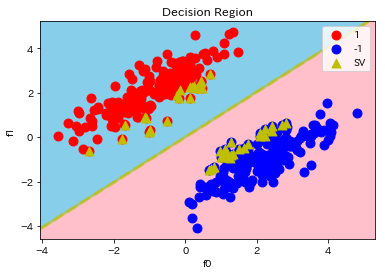

In [85]:
decision_region(X=X_train, y=y_train, model=scratch_svm, step=0.01, title='Decision Region', xlabel='f0', ylabel='f1', target_names=['1', '-1'])

# 【問題6】（アドバンス課題）多項式カーネル関数の作成
 ### sklearn SVM 'poly'のハイパーパラメータ
  #### gamma ： float（デフォルト= 'auto'）
   * 「rbf」、「poly」、および「sigmoid」のカーネル係数。
   * 現在のデフォルトは1 / n_featuresを使用する 'auto'
   * gamma='scale'渡された場合、1 /（n_features * X.var（））
   * 現在のgammaのデフォルト「auto」は、バージョン0.22で「scale」に変更される．

  #### coef0 ： float（デフォルト= 0.0）
   θ0のこと
  #### degree ： int（デフォルト= 3）
   多項式カーネル関数の次数

In [102]:
# パラメータを設定
gamma = 1/len(X)
theta = 0.1
degree = 3

def _poly(X,i,j):
    k = gamma*(X[i]@X[j] + theta)**degree
    return k

In [103]:
_polly(X,1,2)

0.019741768196832637

In [104]:
class ScratchSVMClassifier_poly():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（poly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """

    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False,gamma=0.02,theta=0.1,degree=3):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.gamma = gamma
        self.theta = theta
        self.degree = degree
    
    
    # 線形カーネル
    def _linear(self,X,i,j):
        k = np.dot(X[i].T,X[j])
        return k
    
    
    # 多項式カーネル
    def _poly(self,X,i,j):
        k = self.gamma*(X[i]@X[j] + self.theta)**self.degree
        return k

    
    # ラグランジェ乗数　最急降下法
    def _gradient_descent(self,X,y,lamda):
        lamda_old = np.zeros(lamda.shape)
        for i in range(len(X)):
            sigma = 0
            for j in range(len(X)):
                sigma += lamda[j]*y[i]*y[j]*self._kernel_function(X,i,j)
            lamda_old[i] = lamda[i] + self.lr*(1-sigma)
            if lamda_old[i] < 0:
                lamda_old[i] = 0
        lamda = lamda_old.copy()
        return lamda
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証用データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        if self.kernel == 'linear':
            self._kernel_function = self._linear
        elif self.kernel == 'poly':
            self._kernel_function = self._poly
        else:
            print('カーネル関数が正しくありません．')

        # λの初期化
        lamda = np.zeros(len(X))
        # イテレーションの数だけ学習
        for num in range(self.iter):
            lamda = self._gradient_descent(X,y,lamda)

            # 学習過程の出力
            if self.verbose is True:
                map_result_lamda = map(str, lamda)
                result_lamda = ',\n'.join(map_result_lamda)
                print('\nTrain Data λ学習{0}回目 : \n{1}'.format(num,result_lamda))
            else:
                pass
        
        # サポートベクター
        self.index_support_vectors = np.where(lamda > self.threshold)
        self.X_sv = X[self.index_support_vectors]
        self.n_support_vectors = self.X_sv.shape[0]
        self.lam_sv = lamda[self.index_support_vectors]
        self.y_sv = y[self.index_support_vectors]
        
        
        # テストデータがある場合
        if X_val is not None:
            #カーネル関数が線形なら
            #if self.kernel == linear:
            # λの初期化
            lamda_val = np.zeros(len(X_val))
            # イテレーションの数だけ学習
            for num in range(self.iter):
                lamda_val =  self._gradient_descent(X_val,y_val,lamda_val)
                
                # 学習過程の出力
                if self.verbose is True:
                    map_result_lamda_val = map(str, lamda_val)
                    result_lamda_val = ',\n'.join(map_result_lamda_val)
                    print('\nTest Data λ 学習{0}回目 : \n{1}'.format(num,result_lamda_val))
                else:
                    pass

            # サポートベクター
            self.index_support_vectors_val = np.where(lamda_val > self.threshold)
            self.X_sv_val = X_val[self.index_support_vectors_val]
            self.lam_sv_val = lamda_val[self.index_support_vectors_val]
            self.y_sv_val = y_val[self.index_support_vectors_val]
    
    
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        step1 = X@self.X_sv.T
        y_pred = (self.lam_sv*self.y_sv)@step1.T
        return np.sign(y_pred)

In [105]:
# 初期化，学習，推定
scratch_svm_poly = ScratchSVMClassifier_poly(num_iter=100, lr=0.001, kernel='poly', threshold=1e-5, verbose=True,gamma=0.02,theta=0.1,degree=3)
scratch_svm_poly.fit(X_train,y_train,X_test,y_test)
y_pred_poly = scratch_svm_poly.predict(X_test)


Train Data λ学習0回目 : 
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001,
0.001


Train Data λ学習2回目 : 
0.0025613901111820416,
0.0018836826748671405,
0.0017488147524435506,
0.0017406060283967702,
0.0,
0.0014541423596936237,
0.0006265025826545777,
0.002040796930563723,
0.0026940895986776875,
0.0017307893807158316,
0.0,
0.0019292270140691156,
0.0010203605889080138,
0.0020173103911269295,
0.0007437370384769738,
0.0003876179954087472,
0.00010324426463178616,
0.0019281211266480548,
0.002103394174091286,
0.0020511120968797108,
0.00029923725551673884,
0.0025055311960292983,
0.0018379186327186644,
0.0004569443330602735,
0.0017693463735309624,
0.0014935068658485412,
5.911744968002719e-05,
0.0013043191297432296,
0.0019207159863146737,
0.0005201936967396364,
0.001046494097743597,
0.0006686306414055328,
0.0014573484058520287,
0.002114419908184848,
0.002398419113101362,
0.0011803322095720375,
0.000837696458066625,
0.0016682492546798672,
0.00018223545615236902,
0.002222381528684579,
0.0008381144934236015,
0.0012787341186028668,
0.00032291629415541424,
0.0027657427392923845,
0.0,



Train Data λ学習4回目 : 
0.004087884535281422,
0.0028497940944984205,
0.002444122288398269,
0.002391964612469448,
0.0,
0.00201794308402873,
6.452694099748552e-05,
0.00297945996733114,
0.0043549243533381075,
0.0023416565801082415,
0.0,
0.0027484337898100986,
0.0011528807820568175,
0.002952681688209821,
0.0006048126673614433,
0.0,
0.0,
0.002931372939243191,
0.0031221159107763553,
0.003007054768529998,
0.0,
0.003965354504798187,
0.0025764820851109874,
0.0,
0.0024238585368695454,
0.0019971437717514464,
0.0,
0.001540917279618582,
0.0029107340298870866,
0.0,
0.0009524316971261043,
0.0004895265201372947,
0.0017403425201170156,
0.0033118414854467026,
0.0037275924725064637,
0.0012758096775218196,
0.0004527588612147771,
0.0024912419360816037,
0.0,
0.0034078486225229605,
0.000591183801964308,
0.0016843059151254434,
0.0,
0.004518714836742687,
0.0,
0.0017257062432976724,
0.0,
0.0,
0.0023459542027987543,
0.00044701458038745264,
0.0,
0.0009457308563447181,
0.0,
0.003173789912583579,
0.001295538080886042


Train Data λ学習6回目 : 
0.0055465158974171876,
0.003661721925935958,
0.002952997678179634,
0.0028506973457775924,
0.0,
0.0023678752905028464,
0.0,
0.0037668487181727814,
0.005967424237009196,
0.0027518724930382667,
0.0,
0.003398922671426798,
0.0010088028594835532,
0.0037354924916452753,
0.0001496114417241473,
0.0,
0.0,
0.0037886475571323177,
0.003998982414689672,
0.003813783224676045,
0.0,
0.0053483245190454835,
0.0031327393841042547,
0.0,
0.002884003689838317,
0.0022812718955625756,
0.0,
0.001519405123756616,
0.003750678949739046,
0.0,
0.0005588716161951749,
0.0,
0.0017741639101789119,
0.0043885200027104845,
0.004959098547591623,
0.001092728711517418,
0.0,
0.0031352121446060993,
0.0,
0.004475848197520557,
1.567570131240793e-05,
0.0018522169879840783,
0.0,
0.006236107066071334,
0.0,
0.0019036790238692995,
0.0,
0.0,
0.0027853167922620757,
0.0,
0.0,
0.0006504273612591337,
0.0,
0.004194833785893904,
0.0011453524970947543,
0.0,
0.0017687452994583565,
0.0032422073190910773,
0.0,
0.00348734363


Train Data λ学習8回目 : 
0.006953756306369165,
0.004357988193208818,
0.003342072324109292,
0.003182590103678684,
0.0,
0.002557153997600359,
0.0,
0.004450078036295729,
0.007544073880847155,
0.003012830170690529,
0.0,
0.003923800208158491,
0.0006557453262794994,
0.004403151333919739,
0.0,
0.0,
0.0,
0.00455737519298934,
0.004770360027790015,
0.004509144644836959,
0.0,
0.006679387674994157,
0.0035526034242758728,
0.0,
0.003199446735713245,
0.0024293213136314337,
0.0,
0.0013333834106814308,
0.004477565251272749,
0.0,
0.0,
0.0,
0.0016361616014954228,
0.005375601764995491,
0.006123088401880259,
0.0007312337560490431,
0.0,
0.0036484297917967257,
0.0,
0.005454127730483017,
0.0,
0.0018418262673439102,
0.0,
0.007926305261704954,
0.0,
0.0019401867274400817,
0.0,
0.0,
0.00307510501072428,
0.0,
0.0,
0.00013177790371119488,
0.0,
0.005122036873232799,
0.0007871840297009926,
0.0,
0.001662307239042443,
0.0037295453904717607,
0.0,
0.004094962666914481,
0.004683810294716156,
0.0,
0.0,
0.0046737008221285105,



Train Data λ学習10回目 : 
0.008324499560130228,
0.004970332967018541,
0.0036522756543793146,
0.00343055445024952,
0.0,
0.002629907378573079,
0.0,
0.005063319926599229,
0.009095653090697625,
0.003169744627563985,
0.0,
0.00436072194539141,
0.0001511053230190708,
0.004989323804219204,
0.0,
0.0,
0.0,
0.005266360389705821,
0.005468234376693928,
0.005126380264592798,
0.0,
0.007975813817984052,
0.003877005144910578,
0.0,
0.0034139670111812577,
0.0024875049924053486,
0.0,
0.0010391174083777845,
0.005122375478029317,
0.0,
0.0,
0.0,
0.0013829371968855856,
0.006297789966650154,
0.007241770175330049,
0.00025231875393033273,
0.0,
0.004067481169826925,
0.0,
0.006368104419261406,
0.0,
0.0017021514633172037,
0.0,
0.009596983916420086,
0.0,
0.0018819155798449575,
0.0,
0.0,
0.00325811777293074,
0.0,
0.0,
0.0,
0.0,
0.00598203414789204,
0.00027952287177341115,
0.0,
0.0014222294059308997,
0.0041207773747505136,
0.0,
0.004634233647558839,
0.005424263702557773,
0.0,
0.0,
0.0054138636331691435,
0.0,
0.0051360767


Train Data λ学習12回目 : 
0.009667071382399766,
0.00552271614793692,
0.0038961390793848883,
0.0036086046847330234,
0.0,
0.002619304775493789,
0.0,
0.0056192597136655725,
0.010627408986179074,
0.003247792722392265,
0.0,
0.004728955403810508,
0.0,
0.005512681511171877,
0.0,
0.0,
0.0,
0.005926295242676619,
0.006110468552618367,
0.0056826920101041714,
0.0,
0.009243460414195121,
0.004129383676063516,
0.0,
0.0035520410419967916,
0.0024725738904354502,
0.0,
0.0006574921521675799,
0.005708241903709979,
0.0,
0.0,
0.0,
0.0010390940915720208,
0.007174128313413141,
0.008325065450308505,
0.0,
0.0,
0.004421014947462704,
0.0,
0.007233399495923613,
0.0,
0.0014701383158085735,
0.0,
0.0112527544071656,
0.0,
0.0017457795383055824,
0.0,
0.0,
0.0033600248601546767,
0.0,
0.0,
0.0,
0.0,
0.006795878886086962,
0.0,
0.0,
0.0010821314564685115,
0.0044400611933264516,
0.0,
0.005118300659764596,
0.006117127625096531,
0.0,
0.0,
0.006106306077328472,
0.0,
0.005752734933949949,
0.0,
0.007682050309458751,
0.0063073265380


Train Data λ学習14回目 : 
0.010979680352135394,
0.006009733151374421,
0.004074086708211525,
0.00371645497193705,
0.0,
0.002517869911190405,
0.0,
0.006116618216405577,
0.012138309124480377,
0.003242277196233122,
0.0,
0.005024687607483879,
0.0,
0.005969284454025754,
0.0,
0.0,
0.0,
0.006539493907698287,
0.006693748262283899,
0.006174630818012075,
0.0,
0.010481917855072253,
0.004305225887430527,
0.0,
0.003609082126700831,
0.0023866046531737235,
0.0,
0.0001895926267814761,
0.006229932726206334,
0.0,
0.0,
0.0,
0.0006023710625328821,
0.008000342160865717,
0.009372047144073872,
0.0,
0.0,
0.0047026634525715915,
0.0,
0.008046537900663082,
0.0,
0.0011374697053976395,
0.0,
0.012892582511949295,
0.0,
0.0015351168625546948,
0.0,
0.0,
0.003375200243898777,
0.0,
0.0,
0.0,
0.0,
0.007558902867754654,
0.0,
0.0,
0.0006344784415487386,
0.004681966145773868,
0.0,
0.00554824830804766,
0.006764451391263887,
0.0,
0.0,
0.0067531843155615515,
0.0,
0.0063209714863855255,
0.0,
0.008591690166989784,
0.0069276870790236


Train Data λ学習16回目 : 
0.012264091155564675,
0.006434268034377949,
0.004188497194240152,
0.003757248904700007,
0.0,
0.0023297053983527068,
0.0,
0.006558641301910368,
0.013629607989933372,
0.003159123327680009,
0.0,
0.005252415466039349,
0.0,
0.006363184119124497,
0.0,
0.0,
0.0,
0.007105523754378767,
0.007222288815027595,
0.00660617075122076,
0.0,
0.011692665658925601,
0.004409953041425201,
0.0,
0.0035908385676459756,
0.0022308537015777235,
0.0,
0.0,
0.006690350271335531,
0.0,
0.0,
0.0,
7.856981691864646e-05,
0.008778494178640874,
0.010385048977177591,
0.0,
0.0,
0.004915270898080708,
0.0,
0.00881049833860289,
0.0,
0.0007086799270778852,
0.0,
0.014517345328191949,
0.0,
0.0012497007519479614,
0.0,
0.0,
0.003308759319232993,
0.0,
0.0,
0.0,
0.0,
0.00827300163322191,
0.0,
0.0,
8.533984943289542e-05,
0.004850804913057434,
0.0,
0.005925612398458683,
0.00736612206883558,
0.0,
0.0,
0.007354229877438575,
0.0,
0.006841304294563374,
0.0,
0.009459630358711101,
0.0074924834072847375,
0.00911872031827


Train Data λ学習18回目 : 
0.01352431068581665,
0.006806456787979961,
0.00424985910643693,
0.0037416546855792406,
0.0,
0.0020688479595862867,
0.0,
0.006953644155790034,
0.015104079693300725,
0.0030095578597115944,
0.0,
0.005421798934605751,
0.0,
0.0067033120953599624,
0.0,
0.0,
0.0,
0.007632731973085304,
0.0077040127852880435,
0.006985887692727048,
0.0,
0.012879974595340142,
0.004453888475332532,
0.0,
0.0035082021907949152,
0.002017197750112374,
0.0,
0.0,
0.007099309857441956,
0.0,
0.0,
0.0,
0.0,
0.009516597805340574,
0.011369099105708535,
0.0,
0.0,
0.005070820373196028,
0.0,
0.00953239549058343,
0.0,
0.0001993894440494042,
0.0,
0.01612919819962674,
0.0,
0.0009027152461473149,
0.0,
0.0,
0.003172468555898976,
0.0,
0.0,
0.0,
0.0,
0.008946937113305822,
0.0,
0.0,
0.0,
0.004957316519206249,
0.0,
0.006259112209686949,
0.007930156162037029,
0.0,
0.0,
0.007917523536199584,
0.0,
0.007321979927387383,
0.0,
0.010291913256824941,
0.008009605367930665,
0.009947843479547152,
0.007289131522589672,
0.0,
0


Train Data λ学習20回目 : 
0.014761806789665486,
0.007127520791197058,
0.00426508485154921,
0.0036762678009910174,
0.0,
0.001736999959725312,
0.0,
0.007306207874224416,
0.01656294129377438,
0.0027966923783704,
0.0,
0.005536678396236084,
0.0,
0.006992863201086238,
0.0,
0.0,
0.0,
0.008127865250494231,
0.00814106472753136,
0.0073171555726886,
0.0,
0.014046377257331223,
0.004439690679209195,
0.0,
0.0033641585141628775,
0.0017538397462646756,
0.0,
0.0,
0.007458162778722502,
0.0,
0.0,
0.0,
0.0,
0.010215337083753844,
0.012326352258774317,
0.0,
0.0,
0.005169638893389046,
0.0,
0.010214394931064887,
0.0,
0.0,
0.0,
0.0177288765283346,
0.0,
0.0005044536661255558,
0.0,
0.0,
0.0029699878918956328,
0.0,
0.0,
0.0,
0.0,
0.009580565825942952,
0.0,
0.0,
0.0,
0.005004370718907626,
0.0,
0.0065543529751714786,
0.008462773059252977,
0.0,
0.0,
0.008449463872878366,
0.0,
0.007768918624652583,
0.0,
0.011091526846851541,
0.008482080423387824,
0.010751498160325883,
0.0077173133533803345,
0.0,
0.0,
0.0,
0.0,
0.0005540


Train Data λ学習22回目 : 
0.015977386877445803,
0.00740296812466239,
0.004229690591184605,
0.003556918271085642,
0.0,
0.0013417100190475342,
0.0,
0.007614025074248764,
0.01800633501985236,
0.0025212636449612434,
0.0,
0.005597771265844661,
0.0,
0.007233403383475162,
0.0,
0.0,
0.0,
0.008587130387963493,
0.008533944399863939,
0.007600753001962978,
0.0,
0.015190482657840957,
0.004368487170626448,
0.0,
0.003159487030497252,
0.0014348251246096076,
0.0,
0.0,
0.007772119476842082,
0.0,
0.0,
0.0,
0.0,
0.01087926584653853,
0.01325523774357574,
0.0,
0.0,
0.005218776353095159,
0.0,
0.010858665927358431,
0.0,
0.0,
0.0,
0.01931702590751501,
0.0,
4.876476627852083e-05,
0.0,
0.0,
0.0027044727145955276,
0.0,
0.0,
0.0,
0.0,
0.010179168557253811,
0.0,
0.0,
0.0,
0.004995826934483954,
0.0,
0.0068069196861545635,
0.008960191244541635,
0.0,
0.0,
0.008946306359448453,
0.0,
0.008178024051292466,
0.0,
0.011857628513376533,
0.008910848992662935,
0.0115268858942252,
0.008105618850045125,
0.0,
0.0,
0.0,
0.0,
8.863424


Train Data λ学習24回目 : 
0.017174412527420416,
0.007641542617030214,
0.004145972308630377,
0.003387125852865449,
0.0,
0.0008951039383392058,
0.0,
0.007881376857982228,
0.019436403422662608,
0.0021925707907495657,
0.0,
0.005612758638960586,
0.0,
0.007432393562362353,
0.0,
0.0,
0.0,
0.009009007054875858,
0.008889222002913238,
0.007843557246670867,
0.0,
0.016314133326626786,
0.004248994982486187,
0.0,
0.002903236092732115,
0.0010604704447826187,
0.0,
0.0,
0.008049670854912214,
0.0,
0.0,
0.0,
0.0,
0.011515258995226896,
0.014158657083894426,
0.0,
0.0,
0.005228499240805587,
0.0,
0.011471375327537116,
0.0,
0.0,
0.0,
0.020895499845344945,
0.0,
0.0,
0.0,
0.0,
0.002386063378420948,
0.0,
0.0,
0.0,
0.0,
0.010750280836516251,
0.0,
0.0,
0.0,
0.004941079010821056,
0.0,
0.007017870797033847,
0.0094213490933307,
0.0,
0.0,
0.009406777557273326,
0.0,
0.008549037052711404,
0.0,
0.012594163084758098,
0.009302330336390665,
0.012271942883263137,
0.008455570632071651,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01420195601


Train Data λ学習26回目 : 
0.018355965399009185,
0.007851343286128062,
0.0040143512195245385,
0.003168637111112667,
0.0,
0.00040841901274696855,
0.0,
0.00811139661842897,
0.020855059763186024,
0.0018187593737654384,
0.0,
0.0055884979538102725,
0.0,
0.007596628631571081,
0.0,
0.0,
0.0,
0.00938975650898017,
0.009212643970906065,
0.008051733492243385,
0.0,
0.01741855691064612,
0.004088933541554162,
0.0,
0.0026033437295677393,
0.0006280951554071207,
0.0,
0.0,
0.008298694701882837,
0.0,
0.0,
0.0,
0.0,
0.01212965728075032,
0.01503861442602159,
0.0,
0.0,
0.005208222175386467,
0.0,
0.012058233979184027,
0.0,
0.0,
0.0,
0.022466020009495026,
0.0,
0.0,
0.0,
0.0,
0.0020241059600761527,
0.0,
0.0,
0.0,
0.0,
0.01130077960635047,
0.0,
0.0,
0.0,
0.004848854935473201,
0.0,
0.00718611317836888,
0.009843060311795552,
0.0,
0.0,
0.009827457477623964,
0.0,
0.008879554058989204,
0.0,
0.013304398701158593,
0.009662314655476989,
0.01298276866934749,
0.008766794059693387,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.015073082251


Train Data λ学習28回目 : 
0.01952335700319076,
0.008032726179040712,
0.0038426716239286307,
0.0029091864757202633,
0.0,
0.0,
0.0,
0.008309519889616812,
0.022263507490959077,
0.0014047725474343438,
0.0,
0.005529049087383593,
0.0,
0.007729218350934324,
0.0,
0.0,
0.0,
0.00973599163453788,
0.0095077209514419,
0.00822878481293786,
0.0,
0.01850667073219449,
0.0038925387090866766,
0.0,
0.002264561999874627,
0.00014726288148545966,
0.0,
0.0,
0.008519678819201687,
0.0,
0.0,
0.0,
0.0,
0.012722480573762159,
0.015898574302255195,
0.0,
0.0,
0.005157597586699474,
0.0,
0.012621023787287211,
0.0,
0.0,
0.0,
0.024029128805886837,
0.0,
0.0,
0.0,
0.0,
0.0016218924599544207,
0.0,
0.0,
0.0,
0.0,
0.011830152350445045,
0.0,
0.0,
0.0,
0.004721388722801191,
0.0,
0.007318678958247275,
0.010231718960732843,
0.0,
0.0,
0.010214770427744763,
0.0,
0.009176218534634555,
0.0,
0.013991743971817946,
0.009993865180231837,
0.013664729179047342,
0.009045635986016744,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.015924785587190075,
0.006846


Train Data λ学習30回目 : 
0.020677692805364502,
0.008186155056009739,
0.003638379150192724,
0.0026159703731705257,
0.0,
0.0,
0.0,
0.00848063571104101,
0.023662772555146296,
0.0009548129779354416,
0.0,
0.005437866062534247,
0.0,
0.007832787148029548,
0.0,
0.0,
0.0,
0.01005460101528125,
0.009777437845888689,
0.008377686632021755,
0.0,
0.019581133163814532,
0.0036633952892402098,
0.0,
0.0018909283842287097,
0.0,
0.0,
0.0,
0.008713176704000698,
0.0,
0.0,
0.0,
0.0,
0.013293905270680565,
0.016741662824298013,
0.0,
0.0,
0.005076612585400696,
0.0,
0.013161249863416049,
0.0,
0.0,
0.0,
0.02558528423988796,
0.0,
0.0,
0.0,
0.0,
0.0011821968603166477,
0.0,
0.0,
0.0,
0.0,
0.01233819619399739,
0.0,
0.0,
0.0,
0.004560583543786035,
0.0,
0.007422467811334292,
0.010593920813597632,
0.0,
0.0,
0.010575376611860969,
0.0,
0.009445746076531892,
0.0,
0.014659183220895705,
0.010299577115252655,
0.014323542859457061,
0.009298242651723724,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01675849952525491,
0.0068720006378763495,
0.0


Train Data λ学習32回目 : 
0.021818235180049977,
0.008309119738115656,
0.00340067937029914,
0.0022880669444949307,
0.0,
0.0,
0.0,
0.008623840373077066,
0.025052410020175282,
0.00046707352013574397,
0.0,
0.005313358838702013,
0.0,
0.007905728010556128,
0.0,
0.0,
0.0,
0.010345167681076297,
0.010020524944437307,
0.008497006138168759,
0.0,
0.020641526495199194,
0.003399784607973603,
0.0,
0.0014806816700340742,
0.0,
0.0,
0.0,
0.008876792617664633,
0.0,
0.0,
0.0,
0.0,
0.013841877058803055,
0.01756732088286046,
0.0,
0.0,
0.004962090290298115,
0.0,
0.013677486537442786,
0.0,
0.0,
0.0,
0.027134054913147083,
0.0,
0.0,
0.0,
0.0,
0.00070273405037685,
0.0,
0.0,
0.0,
0.0,
0.01282250455761194,
0.0,
0.0,
0.0,
0.00436419363169527,
0.0,
0.007496868642073819,
0.010929236350598488,
0.0,
0.0,
0.010908857516397428,
0.0,
0.009687640035931472,
0.0,
0.015305923186920197,
0.010578098361513466,
0.014958937579457115,
0.009524020200428423,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.017573173247265667,
0.006865142940457105,
0.0,



Train Data λ学習34回目 : 
0.022945256545712604,
0.00840423708126928,
0.003127988686281128,
0.0019238682804131975,
0.0,
0.0,
0.0,
0.008738101241442054,
0.026432431666387892,
0.0,
0.0,
0.005155569893036606,
0.0,
0.00794849151960193,
0.0,
0.0,
0.0,
0.010606605461000073,
0.010236676396242967,
0.008586849342452397,
0.0,
0.021687294950111815,
0.003101549560369958,
0.0,
0.001033465486635405,
0.0,
0.0,
0.0,
0.009012968803142021,
0.0,
0.0,
0.0,
0.0,
0.014368628970931021,
0.01837459577985976,
0.0,
0.0,
0.004817587323495525,
0.0,
0.014170554762447558,
0.0,
0.0,
0.0,
0.02867570053766227,
0.0,
0.0,
0.0,
0.0,
0.00018461138273807468,
0.0,
0.0,
0.0,
0.0,
0.013285815182145347,
0.0,
0.0,
0.0,
0.00413374859785458,
0.0,
0.007540131773276735,
0.01123650354898603,
0.0,
0.0,
0.01121410112560252,
0.0,
0.009900486296397358,
0.0,
0.015931498433419573,
0.010829630060762456,
0.015570254787263588,
0.009721305462079975,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01836925292617303,
0.00682686164796332,
0.0,
0.0,
0.0,
0.0,
0.0,
0.


Train Data λ学習37回目 : 
0.024612395688764718,
0.008501438517149067,
0.0026609883419002776,
0.001316634734846949,
0.0,
0.0,
0.0,
0.008859972676571102,
0.028485784112327717,
0.0,
0.0,
0.004861052610877858,
0.0,
0.007960329568092474,
0.0,
0.0,
0.0,
0.010952199685189694,
0.010513739005532919,
0.00867041020987227,
0.0,
0.023231153651415704,
0.00259367433879785,
0.0,
0.00029794641506447844,
0.0,
0.0,
0.0,
0.009172156566169093,
0.0,
0.0,
0.0,
0.0,
0.015124591790869888,
0.019553609872551184,
0.0,
0.0,
0.004553502280013945,
0.0,
0.01487033001996304,
0.0,
0.0,
0.0,
0.030975921915144075,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.013948217831283933,
0.0,
0.0,
0.0,
0.003729875254511982,
0.0,
0.007553532369226317,
0.011652349592286795,
0.0,
0.0,
0.011626722267071388,
0.0,
0.010172577525299868,
0.0,
0.016833271959072683,
0.011160071731000525,
0.016449046940355157,
0.009969709518171287,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.019531242459087404,
0.006714958125233131,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00222202987


Train Data λ学習40回目 : 
0.02625227654118898,
0.008549969128532106,
0.0021262614921979807,
0.0006375851018772551,
0.0,
0.0,
0.0,
0.008922980603237452,
0.030519455745389296,
0.0,
0.0,
0.0044984052426509215,
0.0,
0.007911071497807178,
0.0,
0.0,
0.0,
0.0112456190327536,
0.010735226118449499,
0.008693723156225238,
0.0,
0.024745635010866865,
0.002014760970940117,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009282727446181836,
0.0,
0.0,
0.0,
0.0,
0.015844641037957505,
0.020694562348106425,
0.0,
0.0,
0.004240913155403615,
0.0,
0.015524322137920793,
0.0,
0.0,
0.0,
0.033262037879268,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0145780120042914,
0.0,
0.0,
0.0,
0.003259737918960993,
0.0,
0.007507193926625431,
0.012017410488876678,
0.0,
0.0,
0.01198849783881407,
0.0,
0.010390843932092528,
0.0,
0.017691533331042515,
0.011435503765176045,
0.017285570752352278,
0.010162608429254703,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.020655924973318383,
0.006539382492860705,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0016764400250078432,
0.00285197516


Train Data λ学習43回目 : 
0.02786397515890039,
0.008546730476790167,
0.0015251054633396441,
0.0,
0.0,
0.0,
0.0,
0.008926496149189238,
0.03253289917421501,
0.0,
0.0,
0.004065438494380843,
0.0,
0.007798534150173531,
0.0,
0.0,
0.0,
0.0114914552627619,
0.01089846378597182,
0.008654831054156634,
0.0,
0.026230632791800053,
0.0013612191304473097,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00934174981148342,
0.0,
0.0,
0.0,
0.0,
0.01652624737888156,
0.02179676865358161,
0.0,
0.0,
0.0038755485428835124,
0.0,
0.016130711538783364,
0.0,
0.0,
0.0,
0.035533571221100735,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.015171875721600855,
0.0,
0.0,
0.0,
0.0027204297177610692,
0.0,
0.007403235018390402,
0.012335655816137282,
0.0,
0.0,
0.01230365248787855,
0.0,
0.010558495568518374,
0.0,
0.018505368453906084,
0.011654092678738646,
0.01808458480784703,
0.010301429033743242,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.021741952585848247,
0.006297865989795526,
0.0,
0.0,
0.0,
0.0,
0.0,
0.001071459861034041,
0.0022843091546661067,
0.020447


Train Data λ学習46回目 : 
0.029448986055655997,
0.008494233243059672,
0.0008649328078436256,
0.0,
0.0,
0.0,
0.0,
0.008875397975297728,
0.0345272903509794,
0.0,
0.0,
0.003566275543875644,
0.0,
0.007626182243614257,
0.0,
0.0,
0.0,
0.011697567054137393,
0.011007207657757192,
0.008557331767343926,
0.0,
0.027688745197761582,
0.000637700610679627,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009351720842462883,
0.0,
0.0,
0.0,
0.0,
0.017171278004449533,
0.022863638219605523,
0.0,
0.0,
0.003459965040969587,
0.0,
0.016691918881665553,
0.0,
0.0,
0.0,
0.03779124485295953,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.015731530542436232,
0.0,
0.0,
0.0,
0.0021154122530762814,
0.0,
0.007249119425585045,
0.012614533042021538,
0.0,
0.0,
0.012579746024114621,
0.0,
0.010682966673542186,
0.0,
0.019277874544860803,
0.011819058075760487,
0.018852798457771464,
0.01039277987980961,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.022791355127928903,
0.005994034656629215,
0.0,
0.0,
0.0,
0.0,
0.0,
0.000409990054213296,
0.0016497696937478907,
0.02


Train Data λ学習49回目 : 
0.031009069342804126,
0.008398164045396051,
0.00014516336880643973,
0.0,
0.0,
0.0,
0.0,
0.008770946520791802,
0.03650361534485123,
0.0,
0.0,
0.003004775292223437,
0.0,
0.007397993861000254,
0.0,
0.0,
0.0,
0.011861934771343756,
0.011065570745038004,
0.008404701223148665,
0.0,
0.0291203062490568,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00931811464375358,
0.0,
0.0,
0.0,
0.0,
0.01778426606273775,
0.02389669273938699,
0.0,
0.0,
0.0030010916785411807,
0.0,
0.01721144201705139,
0.0,
0.0,
0.0,
0.04003605670926498,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.016262114020751423,
0.0,
0.0,
0.0,
0.0014502263827498967,
0.0,
0.007044474839974709,
0.012852361953997414,
0.0,
0.0,
0.01281495326221184,
0.0,
0.010763067543871047,
0.0,
0.02001061223549034,
0.01193369305318314,
0.019588043520515522,
0.01043672190358218,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.023806689593644802,
0.005632009106247543,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0009513959772083658,
0.022281521620301725,
0.0,
0.0,
0.0072302682


Train Data λ学習52回目 : 
0.03254533055174972,
0.008257642139694465,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008615583520535843,
0.0384627772991836,
0.0,
0.0,
0.0023839580534437367,
0.0,
0.0071164554253303385,
0.0,
0.0,
0.0,
0.01198454865892909,
0.011075678992394544,
0.008199588588640616,
0.0,
0.030526413428523212,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009240348818169243,
0.0,
0.0,
0.0,
0.0,
0.018364062287175013,
0.024897572543248182,
0.0,
0.0,
0.002496251133484075,
0.0,
0.017690768576932744,
0.0,
0.0,
0.0,
0.04226851132074268,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.016761179795212734,
0.0,
0.0,
0.0,
0.0007265939167968494,
0.0,
0.006790557791499647,
0.013049296443796437,
0.0,
0.0,
0.013009344045274313,
0.0,
0.01079934431147683,
0.0,
0.020705574270144373,
0.012000370909226152,
0.020290090709063287,
0.010434685901211771,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.024789386367465215,
0.00521439529568384,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00019232493677061568,
0.02314504102920484,
0.0,
0.0,
0.006978071706006871,
0.0


Train Data λ学習55回目 : 
0.03405841638253353,
0.00807197593923221,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008411983503872535,
0.04040537964448641,
0.0,
0.0,
0.0017058618581355664,
0.0,
0.006783091546192034,
0.0,
0.0,
0.0,
0.012069692510753679,
0.01103921357432723,
0.007943749067951904,
0.0,
0.03190845871825484,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.009117907722125273,
0.0,
0.0,
0.0,
0.0,
0.018909851985833403,
0.025868211995351963,
0.0,
0.0,
0.0019436687774056088,
0.0,
0.018130692491408196,
0.0,
0.0,
0.0,
0.04448886935167954,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.017227110690714916,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0064915133878459255,
0.01320939528826922,
0.0,
0.0,
0.013167038502051859,
0.0,
0.010795864662065027,
0.0,
0.02136445690539365,
0.012020619838673214,
0.020962666185622737,
0.010390377471423637,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.02574026613137917,
0.004742801417447867,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.02397470348377097,
0.0,
0.0,
0.0066768099821794035,
0.0,
0.03971168521865565,
0.0,
0.0,
0.0,


Train Data λ学習58回目 : 
0.03554840443310971,
0.0078398630421771,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008162616460290904,
0.042331680872319484,
0.0,
0.0,
0.0009712791765470447,
0.0,
0.006398195471200412,
0.0,
0.0,
0.0,
0.012122862072831997,
0.010956946460084485,
0.0076378141973703325,
0.0,
0.03326789617365602,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008949593469347159,
0.0,
0.0,
0.0,
0.0,
0.019420478910657585,
0.026810173841243446,
0.0,
0.0,
0.0013414302420184155,
0.0,
0.01853103046999486,
0.0,
0.0,
0.0,
0.04669707386305881,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.017658345889232804,
0.0,
0.0,
0.0,
0.0,
0.0,
0.006152062985251791,
0.01333779243217892,
0.0,
0.0,
0.013293285933239994,
0.0,
0.010757598479846038,
0.0,
0.021988479541628223,
0.011994909506671547,
0.02161060376794706,
0.010307845466515487,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.026659362906764742,
0.004217558662472854,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.024770819752546386,
0.0,
0.0,
0.006326076699271208,
0.0,
0.04159013971728064,
0.0,
0.0,
0.0


Train Data λ学習61回目 : 
0.03701700338867177,
0.007563961358852843,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007872011256829856,
0.04424298493241041,
0.0,
0.0,
0.00018473841882282375,
0.0,
0.005965671491801529,
0.0,
0.0,
0.0,
0.012148874523745816,
0.010832762443272621,
0.007285759376472897,
0.0,
0.03460704447133971,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008738077413076679,
0.0,
0.0,
0.0,
0.0,
0.01989786747929717,
0.02772646717910701,
0.0,
0.0,
0.0006921237009945163,
0.0,
0.01889455547038489,
0.0,
0.0,
0.0,
0.048893965699312154,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01805659364895459,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005777517952404883,
0.013439165288169878,
0.0,
0.0,
0.013392776172843707,
0.0,
0.010689453530924677,
0.0,
0.022580780402514763,
0.011926827717480217,
0.022237798731047382,
0.0101919537788977,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.027548996905600153,
0.003642746686764751,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.025535984402130823,
0.0,
0.0,
0.005929303361359184,
0.0,
0.04345289306267222,
0.0,
0.0,
0.0,


Train Data λ学習64回目 : 
0.03846432285440373,
0.007244940056532271,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007538276814512464,
0.046139208954675236,
0.0,
0.0,
0.0,
0.0,
0.005485690348007437,
0.0,
0.0,
0.0,
0.012142643007497723,
0.010666532818032828,
0.006887489144221045,
0.0,
0.03592470170748542,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008484026828730729,
0.0,
0.0,
0.0,
0.0,
0.020342512194641848,
0.02861605988346773,
0.0,
0.0,
0.0,
0.0,
0.01922165008605102,
0.0,
0.0,
0.0,
0.051079662138699924,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.018422307837115945,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005363771957088422,
0.0135087918118851,
0.0,
0.0,
0.01346066533068616,
0.0,
0.010586935646065347,
0.0,
0.02314058538350165,
0.011816371566945946,
0.02283976978314085,
0.010039269287207131,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.028409369236639954,
0.0030185253822223477,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.026270216464081814,
0.0,
0.0,
0.005487022056224156,
0.0,
0.045299881120474166,
0.0,
0.0,
0.0,
0.005672673363716044,
0.0,
0.00745


Train Data λ学習67回目 : 
0.03988921262614885,
0.006881522191858314,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007158373014314737,
0.04801945527622947,
0.0,
0.0,
0.0,
0.0,
0.004955636339395311,
0.0,
0.0,
0.0,
0.012101397581848491,
0.010455790323176043,
0.006440308410207501,
0.0,
0.03721931917382735,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.008186100214870456,
0.0,
0.0,
0.0,
0.0,
0.020753588343867136,
0.02947703659397117,
0.0,
0.0,
0.0,
0.0,
0.019510515968107003,
0.0,
0.0,
0.0,
0.05325360608771824,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01875503610522346,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00490763870583587,
0.013543971494709007,
0.0,
0.0,
0.013494252169489311,
0.0,
0.010447173329486872,
0.0,
0.02366575268041867,
0.011661114164288479,
0.02341428584205667,
0.009846842225276225,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.029238935187834155,
0.002342159858237047,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.026971757267983752,
0.0,
0.0,
0.0049973562210766384,
0.0,
0.04713017466082544,
0.0,
0.0,
0.0,
0.005261128800936637,
0.0,
0.007170


Train Data λ学習70回目 : 
0.04129301373328165,
0.006474619788032493,
0.0,
0.0,
0.0,
0.0,
0.0,
0.006736628242015523,
0.04988484137561027,
0.0,
0.0,
0.0,
0.0,
0.004378581465957894,
0.0,
0.0,
0.0,
0.012030568905565758,
0.010203518395306376,
0.005947495507897118,
0.0,
0.03849318595725852,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.007845336009754796,
0.0,
0.0,
0.0,
0.0,
0.021131534047870916,
0.03031205813749288,
0.0,
0.0,
0.0,
0.0,
0.019763134760656317,
0.0,
0.0,
0.0,
0.055416418317022605,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.019054541101974434,
0.0,
0.0,
0.0,
0.0,
0.0,
0.004414482871937472,
0.013549861850764571,
0.0,
0.0,
0.013498764428280888,
0.0,
0.01027537169496624,
0.0,
0.024159143423586667,
0.011463975303301803,
0.02396599508093948,
0.009619482549392266,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.03003946695100113,
0.0016168697391212039,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.02764271694840739,
0.0,
0.0,
0.004462225703826917,
0.0,
0.04894492199228928,
0.0,
0.0,
0.0,
0.004817178452079025,
0.0,
0.00684


Train Data λ学習73回目 : 
0.04267698869527295,
0.006027960519712417,
0.0,
0.0,
0.0,
0.0,
0.0,
0.006275938258868419,
0.05173625739940153,
0.0,
0.0,
0.0,
0.0,
0.003757233321112056,
0.0,
0.0,
0.0,
0.01193434816870349,
0.009911502405009494,
0.005411649607759759,
0.0,
0.03974788795556019,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0074652905515365684,
0.0,
0.0,
0.0,
0.0,
0.02147941800757496,
0.031122499916113676,
0.0,
0.0,
0.0,
0.0,
0.019981744646293736,
0.0,
0.0,
0.0,
0.057568814884329626,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01932440766813933,
0.0,
0.0,
0.0,
0.0,
0.0,
0.003887931656329271,
0.013530387186800963,
0.0,
0.0,
0.013478210367216257,
0.0,
0.010075337222994682,
0.0,
0.024622722466102174,
0.011227352663737313,
0.024498518248130402,
0.009360306217008244,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.030812699966395594,
0.0008454651965535535,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.02828487002620704,
0.0,
0.0,
0.003884169070112224,
0.0,
0.050745051028102395,
0.0,
0.0,
0.0,
0.004345810964638585,
0.0,
0.00


Train Data λ学習76回目 : 
0.04404320405720232,
0.005546293910897067,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005780868479287295,
0.05357517679597717,
0.0,
0.0,
0.0,
0.0,
0.0030961851049852228,
0.0,
0.0,
0.0,
0.01181731995062352,
0.009583692432950484,
0.004837253438245093,
0.0,
0.04098577251983647,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00705058354876933,
0.0,
0.0,
0.0,
0.0,
0.021800974207823995,
0.03191109882322207,
0.0,
0.0,
0.0,
0.0,
0.020169913703306327,
0.0,
0.0,
0.0,
0.05971189507837663,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.019568662340214496,
0.0,
0.0,
0.0,
0.0,
0.0,
0.003332891953199938,
0.013489979796312602,
0.0,
0.0,
0.013437043808992724,
0.0,
0.009851674694272313,
0.0,
0.02505976621120347,
0.010955351806309563,
0.025015562689384447,
0.009073772718377563,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.031561477660449824,
3.2727412746429835e-05,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.028901215718114676,
0.0,
0.0,
0.0032676236186230476,
0.0,
0.052532099457242604,
0.0,
0.0,
0.0,
0.0038522264309174045,
0.0,
0.


Train Data λ学習79回目 : 
0.04539278928612978,
0.0050328596886995945,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00525390328114269,
0.05540238092812224,
0.0,
0.0,
0.0,
0.0,
0.002397924451206771,
0.0,
0.0,
0.0,
0.011682745654704122,
0.009222140130623065,
0.0042266871805861075,
0.0,
0.04220815596815857,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.006604318451132587,
0.0,
0.0,
0.0,
0.0,
0.022098832235985584,
0.03267927931404395,
0.0,
0.0,
0.0,
0.0,
0.02032967141931902,
0.0,
0.0,
0.0,
0.0618462820819654,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01979032760789266,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0027524194118648143,
0.013431727355852845,
0.0,
0.0,
0.013378400724144096,
0.0,
0.0096074535248517,
0.0,
0.02547200379660021,
0.010650165505211832,
0.02551988583436881,
0.008762572990487286,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.032287369160937454,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.029493361012916858,
0.0,
0.0,
0.002615301222321632,
0.0,
0.05430688428422946,
0.0,
0.0,
0.0,
0.0033402444506087704,
0.0,
0.005667602464355882,
0.0,


Train Data λ学習82回目 : 
0.046726209678903965,
0.004489553920294027,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0046964002275642165,
0.05721819379225785,
0.0,
0.0,
0.0,
0.0,
0.0016634802834228077,
0.0,
0.0,
0.0,
0.011533419454645689,
0.008827746185645335,
0.003580935593179868,
0.0,
0.04341581132347855,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.006128267480157152,
0.0,
0.0,
0.0,
0.0,
0.022374608800878742,
0.03342783448106562,
0.0,
0.0,
0.0,
0.0,
0.020461900841306103,
0.0,
0.0,
0.0,
0.06397224071722911,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.019991454133731233,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0021488599030250743,
0.013358242077364113,
0.0,
0.0,
0.013304951913864908,
0.0,
0.009345188218877946,
0.0,
0.025860248781940626,
0.010312697388658445,
0.0260139033882469,
0.008428699363741278,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.03299102956509361,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.030061965955178346,
0.0,
0.0,
0.0019286120903306795,
0.0,
0.05606974247086876,
0.0,
0.0,
0.0,
0.0028131903385172703,
0.0,
0.00522197518458484


Train Data λ学習85回目 : 
0.04804533878250497,
0.00392059409726239,
0.0,
0.0,
0.0,
0.0,
0.0,
0.004112193468218942,
0.05902392755438375,
0.0,
0.0,
0.0,
0.0,
0.0008970438405244538,
0.0,
0.0,
0.0,
0.011372535418582429,
0.00840428917141276,
0.0029040580332607246,
0.0,
0.04461065873978729,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005626550382371396,
0.0,
0.0,
0.0,
0.0,
0.022631578767146346,
0.03415918924934755,
0.0,
0.0,
0.0,
0.0,
0.02056986466171366,
0.0,
0.0,
0.0,
0.06609076286161428,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0201754918540465,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0015259689873004497,
0.01327265797206735,
0.0,
0.0,
0.013219822977580894,
0.0,
0.009068237446658776,
0.0,
0.026227351098491773,
0.009946672893260221,
0.026500116552020943,
0.00807564373201559,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.033675049472316816,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.030609746392817414,
0.0,
0.0,
0.0012118192046545232,
0.0,
0.05782204705872756,
0.0,
0.0,
0.0,
0.0022746054378351486,
0.0,
0.0047558800792353115,
0


Train Data λ学習88回目 : 
0.049351799571948254,
0.0033296020375873352,
0.0,
0.0,
0.0,
0.0,
0.0,
0.003504587657222407,
0.06082071974276573,
0.0,
0.0,
0.0,
0.0,
0.00010224295040647347,
0.0,
0.0,
0.0,
0.011202758790375559,
0.00795502044590656,
0.00219956912622686,
0.0,
0.045794350625050495,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.005102707373701689,
0.0,
0.0,
0.0,
0.0,
0.02287255128656224,
0.03487542309197593,
0.0,
0.0,
0.0,
0.0,
0.020656384360611315,
0.0,
0.0,
0.0,
0.06820270777329847,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.020345392212833113,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0008869257111371684,
0.013177597059144138,
0.0,
0.0,
0.01312562543884984,
0.0,
0.008779425389566829,
0.0,
0.026575775254668588,
0.009555317702059387,
0.026980598481748115,
0.007706369698379487,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.03434167158176569,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.031139054604028788,
0.0,
0.0,
0.00046857680178830037,
0.0,
0.05956498832199909,
0.0,
0.0,
0.0,
0.0017274316407305103,
0.0,
0.0042729693902240


Train Data λ学習91回目 : 
0.05064516098488503,
0.00271592305017544,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0028735004393191186,
0.06260832101324366,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.011025699167487074,
0.007478897501131593,
0.0014665916211301874,
0.0,
0.046966960590112745,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.004556043741508387,
0.0,
0.0,
0.0,
0.0,
0.02309713819947718,
0.03557635062349587,
0.0,
0.0,
0.0,
0.0,
0.020720662804465082,
0.0,
0.0,
0.0,
0.07030784951455034,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.020501031273004778,
0.0,
0.0,
0.0,
0.0,
0.0,
0.00023278559351891034,
0.013074537126327673,
0.0,
0.0,
0.013023885484774794,
0.0,
0.00848009228990201,
0.0,
0.026905188710345525,
0.009137802742143437,
0.02745677236869726,
0.007321663974494037,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.03499027934559821,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.031649289176608586,
0.0,
0.0,
0.0,
0.0,
0.06129829698475815,
0.0,
0.0,
0.0,
0.0011736162622130169,
0.0,
0.0037731540593987467,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.


Train Data λ学習94回目 : 
0.051923800525887485,
0.0020758176702707592,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0022170801457938884,
0.06438571098168028,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.010842155471435112,
0.006972562580158402,
0.0007017971782116427,
0.0,
0.048127728101932325,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.003982861815527148,
0.0,
0.0,
0.0,
0.0,
0.023302551459044217,
0.03626067959626802,
0.0,
0.0,
0.0,
0.0,
0.020759720236607243,
0.0,
0.0,
0.0,
0.07240530681066787,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.02063975428676894,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.012964146505901325,
0.0,
0.0,
0.012915329858852857,
0.0,
0.008170662887075738,
0.0,
0.02721377348698856,
0.008691016051321745,
0.027929439766918213,
0.006921185918024135,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.035618581753623695,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.032138177844042055,
0.0,
0.0,
0.0,
0.0,
0.06302088895869315,
0.0,
0.0,
0.0,
0.0006142211624658742,
0.0,
0.0032532056032997143,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.03936320321664


Train Data λ学習97回目 : 
0.05318746561792749,
0.0014087945200097279,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0015344946524849588,
0.0661526975658392,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.010650374865029923,
0.006435335338030203,
0.0,
0.0,
0.04927620457960298,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0033826740267179386,
0.0,
0.0,
0.0,
0.0,
0.023488431868210362,
0.03692780545757678,
0.0,
0.0,
0.0,
0.0,
0.020773128205745926,
0.0,
0.0,
0.0,
0.07449495670495533,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.02076125396629476,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.012844797335562876,
0.0,
0.0,
0.0127982891127535,
0.0,
0.007849575994948638,
0.0,
0.027501015976156,
0.008214414954139486,
0.02839702650280948,
0.006503651814149477,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.03622623008760125,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.03260533228390676,
0.0,
0.0,
0.0,
0.0,
0.06473256548441449,
0.0,
0.0,
0.0,
4.712028503015174e-05,
0.0,
0.0027127651533592825,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.040135062372220455,
0.0,
0.01661741436110


Test Data λ 学習1回目 : 
0.0011196262140446727,
0.00047602256750234903,
0.0016836634322998933,
0.0016662891329136081,
0.0016708122585143226,
0.0013565063002751374,
0.0015785361735754025,
0.0017038676364838526,
0.0016897125271961321,
0.0012964821806309428,
0.001366961361740582,
0.0009927552403122192,
0.0015696309809307436,
0.0017091991082109068,
0.00113832529651145,
0.00157228667533036,
0.0009417452425700982,
0.0013429463260169088,
0.0018229479268754047,
0.001618120546282761,
0.0017941925079068164,
0.0011345349636390097,
0.0017568102476401644,
0.0018385943766222987,
0.0018536022373963638,
0.0017737883274333683,
0.0015483272190218971,
0.001467904537272561,
0.0016894360645180865,
0.0018847961853735934,
0.0016192149822209937,
0.0013722759012204872,
0.0006282498870961739,
0.0014493042892002516,
0.0014122111993493728,
0.0019235560377126692,
0.0017078815772992421,
0.0017298229742962385,
0.00167382460477559,
0.0011995600110637791,
0.001845765778510638,
0.0018275683846660134,
0.0018316403464219396


Test Data λ 学習4回目 : 
0.0006582150686777178,
0.0,
0.003598895781277595,
0.0032298309921428054,
0.003164499867350703,
0.0016760427911806327,
0.002679361628634774,
0.003387714727545283,
0.0032283683334266003,
0.0019332693408403209,
0.0020905682663148488,
0.00029863413947352094,
0.0026017364551046466,
0.0033513353936166623,
0.00016888226850622824,
0.003033432015101257,
0.0,
0.0014614815048687698,
0.004190255134446523,
0.0031679611542009523,
0.0038843034083570287,
0.000380601958283754,
0.003872226061344423,
0.004126323448991122,
0.004163871787889268,
0.003975294519661154,
0.0029852468970759747,
0.002400264878315564,
0.0034631975860423886,
0.004409531200794139,
0.002918696867515999,
0.0019483139406638646,
0.0,
0.002063555850101395,
0.0017775925039774446,
0.004565148365614963,
0.0034368199321899596,
0.003521294079348308,
0.003137376086960763,
0.0007482032680570284,
0.004166429630112075,
0.004011998241385448,
0.004048749353973621,
0.0032465917169689647,
0.0,
0.004155774913983035,
0.0024191008


Test Data λ 学習9回目 : 
0.0,
0.0,
0.006239854554015745,
0.0049118702308538174,
0.004673851401529942,
0.0005153186403184639,
0.003276589857806432,
0.005565021507116619,
0.00491796250806257,
0.0018341763259134393,
0.0020663641657119357,
0.0,
0.003288476658011257,
0.005217654696330325,
0.0,
0.004630990694424477,
0.0,
0.0,
0.007794014161438991,
0.004907270119622301,
0.00693975534143562,
0.0,
0.00690894087592836,
0.007476288515476844,
0.007583968436946237,
0.007220722382259813,
0.004575422901345906,
0.002721924025260203,
0.005676918399113171,
0.008319750040459716,
0.00397709889020726,
0.001473164563414611,
0.0,
0.002043124749114625,
0.0006704640074054701,
0.008758223339518907,
0.005496299712446744,
0.005719775604517061,
0.004615903789869247,
0.0,
0.007593082085213881,
0.007155618568718082,
0.0073047825234818,
0.005154432120148738,
0.0,
0.007620244199024888,
0.0033571328377842552,
0.002449555218379218,
0.005050591142791431,
0.0,
0.005841816559760929,
0.004435628043353994,
0.0010216927875830962


Test Data λ 学習13回目 : 
0.0,
0.0,
0.008012488880339197,
0.005734301546705961,
0.005328932354618147,
0.0,
0.0030738252888749444,
0.0069013282321548205,
0.005759545890462185,
0.0010257591075299704,
0.0012988759032788071,
0.0,
0.00320116388883443,
0.006216918466057525,
0.0,
0.0054085021834546585,
0.0,
0.0,
0.010472493114152288,
0.005809962385416064,
0.009105501083899301,
0.0,
0.009048616442730539,
0.009902196816649014,
0.010072303352127401,
0.009561159220507856,
0.005353772039468474,
0.0022725706975563202,
0.007025737380695953,
0.011276629504114018,
0.004200214919933446,
0.00026722306336819776,
0.0,
0.0013265300786434399,
0.0,
0.011988127239000742,
0.006690467703889446,
0.007034598825279775,
0.005248615403295084,
0.0,
0.010084600586423442,
0.009391714995986995,
0.009645441965997347,
0.006247139887041819,
0.0,
0.010159189049257335,
0.0035962066032388927,
0.0018694698716055823,
0.005996977517093776,
0.0,
0.0075432095961436105,
0.004979157120486546,
0.0,
0.005091443932049104,
0.00695544867961


Test Data λ 学習18回目 : 
0.0,
0.0,
0.00998982310755986,
0.006326038711295304,
0.005666041435259922,
0.0,
0.0022297018770618417,
0.008189376162247254,
0.006344070895301769,
0.0,
0.0,
0.0,
0.0024956336383275815,
0.007026740151931302,
0.0,
0.006012841327866463,
0.0,
0.0,
0.013671091584077588,
0.006562815205477174,
0.011550049612398623,
0.0,
0.011508217979114483,
0.012717156272228709,
0.012959049925819118,
0.012301876659038436,
0.005977432165683196,
0.0011585633288435644,
0.00837770075971173,
0.01483416654808256,
0.0039453978083980185,
0.0,
0.0,
0.0,
0.0,
0.015911090915198715,
0.007799328616980677,
0.008297873009241171,
0.005542726641173461,
0.0,
0.01298757001569602,
0.011929607878779967,
0.012326353589769214,
0.0071980832257712525,
0.0,
0.01314770937041383,
0.0034040668565892313,
0.0005958128379027183,
0.006785835254884146,
0.0,
0.00937900845596963,
0.005197379849279626,
0.0,
0.005380535314410437,
0.008179949176766245,
0.0,
0.0,
0.005694156546135788,
0.005618614581430225,
0.0060342436594493


Test Data λ 学習24回目 : 
0.0,
0.0,
0.012104613981482928,
0.006595168749848964,
0.005581154303432739,
0.0,
0.0006160138273190203,
0.009318682014606863,
0.006558102893435728,
0.0,
0.0,
0.0,
0.0010099767054714043,
0.007549197216537948,
0.0,
0.006350340476314147,
0.0,
0.0,
0.017350926056481517,
0.00707759000657815,
0.014196849507963745,
0.0,
0.01423373648056729,
0.015874107039479633,
0.016192424870874186,
0.015393764422933505,
0.00635023793619437,
0.0,
0.009657454669293422,
0.018963014898504556,
0.0030993448512524903,
0.0,
0.0,
0.0,
0.0,
0.02049875785325041,
0.008740159902087966,
0.009428876812818126,
0.005383447230778127,
0.0,
0.016257430593573204,
0.014707041606204433,
0.015284477435123383,
0.007886665208783611,
0.0,
0.016544109588195632,
0.0026085582508805767,
0.0,
0.0073320578261122935,
0.0,
0.011244510459310022,
0.004992495501286364,
0.0,
0.0052685297152484005,
0.009246074175653958,
0.0,
0.0,
0.005626828834298707,
0.0055227301294872265,
0.006327365252030223,
0.0,
0.011026830697132685,
0


Test Data λ 学習29回目 : 
0.0,
0.0,
0.013673765928850123,
0.006545839763429772,
0.005220813315718301,
0.0,
0.0,
0.010038534851617353,
0.006464461576055903,
0.0,
0.0,
0.0,
0.0,
0.007724598750230491,
0.0,
0.006354415832247827,
0.0,
0.0,
0.020303308810833587,
0.007240806132338808,
0.016250637666603802,
0.0,
0.016344830373801793,
0.018369157551480476,
0.018755986171338748,
0.017826921525297797,
0.006382440153823838,
0.0,
0.010496342979070209,
0.022314220682752007,
0.002067972548066818,
0.0,
0.0,
0.0,
0.0,
0.024255504520432108,
0.009282505689069371,
0.010139241861297178,
0.004959463450087614,
0.0,
0.018851982528279174,
0.016869882280391567,
0.017607796575498876,
0.00821742280907684,
0.0,
0.019248850944897977,
0.0016672303813220562,
0.0,
0.0075262352744038625,
0.0,
0.012645089305602207,
0.004525211477470381,
0.0,
0.004882276230759797,
0.009901013693587897,
0.0,
0.0,
0.005285052631874716,
0.005153596511498923,
0.006294721647307652,
0.0,
0.012202784263513712,
0.0,
0.0,
0.011291397459264245,
0.008


Test Data λ 学習34回目 : 
0.0,
0.0,
0.015061790376670225,
0.006265144490617884,
0.004624499943820905,
0.0,
0.0,
0.01060184652587924,
0.006162540032748238,
0.0,
0.0,
0.0,
0.0,
0.00769261439532285,
0.0,
0.006103925557797572,
0.0,
0.0,
0.02315051130296874,
0.007164990496123856,
0.01819769398927295,
0.0,
0.018309403413614422,
0.020749158870864527,
0.021217460283784,
0.020127278101994495,
0.00615464137618962,
0.0,
0.011133484982746673,
0.025588407175495757,
0.00076606203235109,
0.0,
0.0,
0.0,
0.0,
0.027962330966766778,
0.009618914059227573,
0.010657506557349256,
0.004307332480147866,
0.0,
0.021337855859067265,
0.018912822275186737,
0.019825634151600876,
0.008370086427446532,
0.0,
0.02184243670187711,
0.0005583563519622615,
0.0,
0.007492527564334943,
0.0,
0.013968170596322873,
0.003803087467769988,
0.0,
0.004241998124442885,
0.010367209975780976,
0.0,
0.0,
0.00471742608993953,
0.004547602363327392,
0.006012095590118577,
0.0,
0.013200374332258298,
0.0,
0.0,
0.012080703463140333,
0.00866560473393


Test Data λ 学習39回目 : 
0.0,
0.0,
0.016293679944103405,
0.005797479979049918,
0.0038374723159636886,
0.0,
0.0,
0.011028492299404296,
0.005688326256351371,
0.0,
0.0,
0.0,
0.0,
0.007492214792431704,
0.0,
0.005637395879181251,
0.0,
0.0,
0.02590805463463732,
0.006889194606779026,
0.020051209056567036,
0.0,
0.020149838369813086,
0.023035089327702703,
0.023595447768544973,
0.022314095196001246,
0.0057035717273031614,
0.0,
0.011603247811686599,
0.028800233467413564,
0.0,
0.0,
0.0,
0.0,
0.0,
0.03162764371574859,
0.009786989026547824,
0.011020795558445533,
0.003468598085220677,
0.0,
0.023736148216874645,
0.02085640874526233,
0.021954807765812667,
0.008368167247793124,
0.0,
0.024343778156411283,
0.0,
0.0,
0.007272984135497422,
0.0,
0.015210716908981365,
0.0028742593920811324,
0.0,
0.0033931544459502748,
0.010678559811905776,
0.0,
0.0,
0.003963024161358852,
0.0037480076235561826,
0.005519837569955878,
0.0,
0.014051867779991163,
0.0,
0.0,
0.012729470195434385,
0.008725102865769168,
0.00880578190278


Test Data λ 学習44回目 : 
0.0,
0.0,
0.01740396170685191,
0.0051843135562731155,
0.0028945540681456967,
0.0,
0.0,
0.011299109279690949,
0.005052841054139979,
0.0,
0.0,
0.0,
0.0,
0.007148474852284044,
0.0,
0.00500446587082166,
0.0,
0.0,
0.028596419302111795,
0.006460981737856322,
0.02179635482878938,
0.0,
0.02189488755655876,
0.025248221833880872,
0.02589882353218518,
0.02441305925225559,
0.005078975773901876,
0.0,
0.011945974405098198,
0.031964031307941496,
0.0,
0.0,
0.0,
0.0,
0.0,
0.03525263631358137,
0.009825472160365417,
0.011260430849335257,
0.002464508198825515,
0.0,
0.026065229183395742,
0.02271216561814863,
0.0239948996082244,
0.008199778902329345,
0.0,
0.026775167675337306,
0.0,
0.0,
0.006911273661662622,
0.0,
0.01629565408232343,
0.001786431612062115,
0.0,
0.002385561254099165,
0.010860238130887616,
0.0,
0.0,
0.0030439879166324307,
0.0027906314645631375,
0.004867551274531306,
0.0,
0.014791614610030644,
0.0,
0.0,
0.013251704869346388,
0.008617354653501365,
0.008686704747844989,
0.0


Test Data λ 学習49回目 : 
0.0,
0.0,
0.018427091138875917,
0.004476212044897201,
0.0018492987155290586,
0.0,
0.0,
0.011453889418342123,
0.00430607581492572,
0.0,
0.0,
0.0,
0.0,
0.006709391424984477,
0.0,
0.004255283149450766,
0.0,
0.0,
0.031236175210506298,
0.005929005629310306,
0.023460672061356463,
0.0,
0.02357357411566642,
0.027413936872924843,
0.02815163984884224,
0.02644994577661662,
0.004330713232539561,
0.0,
0.012203614509873973,
0.03509626196379116,
0.0,
0.0,
0.0,
0.0,
0.0,
0.03884939472883558,
0.00977947745697327,
0.011419324021246974,
0.0013487560674663537,
0.0,
0.02834914192652824,
0.024508472760939076,
0.025971803860348117,
0.00790974248709627,
0.0,
0.029159771688001976,
0.0,
0.0,
0.0064554512232553865,
0.0,
0.017251169122510707,
0.0005943414790322601,
0.0,
0.0012736484910913577,
0.010955989348317824,
0.0,
0.0,
0.002013723055019429,
0.0017296590508962218,
0.004105834416315681,
0.0,
0.01545831035146305,
0.0,
0.0,
0.013687698625616062,
0.008385898760233657,
0.008461487728293852,



Test Data λ 学習55回目 : 
0.0,
0.0,
0.01955777820573115,
0.0035279072370515887,
0.0004883725952849789,
0.0,
0.0,
0.01150673404625828,
0.0032894249629482793,
0.0,
0.0,
0.0,
0.0,
0.006082160213489333,
0.0,
0.0032286750982544084,
0.0,
0.0,
0.03435030963904649,
0.005178669216528889,
0.025364766658498086,
0.0,
0.025515321203024525,
0.029963460245777656,
0.03080103727378888,
0.028825582970280726,
0.003295506518716399,
0.0,
0.012422051771358654,
0.03882197579770288,
0.0,
0.0,
0.0,
0.0,
0.0,
0.043134561916297484,
0.009636302504694685,
0.011526194187679186,
0.0,
0.0,
0.031042980255473456,
0.026600655129895064,
0.02827413715980545,
0.007424305215763171,
0.0,
0.03197144110810485,
0.0,
0.0,
0.005809490058826151,
0.0,
0.018235153683157444,
0.0,
0.0,
0.0,
0.010980667511869087,
0.0,
0.0,
0.0006589581685889215,
0.0003484011288515333,
0.0030733320914116498,
0.0,
0.016182029683980612,
0.0,
0.0,
0.014118458595573044,
0.007966646380821837,
0.008074693360033167,
0.0,
0.0,
0.0,
0.023961960369271642,
0.00213163


Test Data λ 学習62回目 : 
0.0,
0.0,
0.020729537380806635,
0.0022371158049647294,
0.0,
0.0,
0.0,
0.01134914288919946,
0.001886934799766103,
0.0,
0.0,
0.0,
0.0,
0.005162854833535759,
0.0,
0.0018286427735865489,
0.0,
0.0,
0.03789955080297781,
0.004117714812469557,
0.027433183065405535,
0.0,
0.02766483442855303,
0.032848594629644436,
0.03379262703430127,
0.03149057590322596,
0.0018771868381430973,
0.0,
0.01252214712017805,
0.043107793742760796,
0.0,
0.0,
0.0,
0.0,
0.0,
0.048078817470157166,
0.009310119156360009,
0.011492356631077767,
0.0,
0.0,
0.03409710059405446,
0.028929343868928314,
0.030838167783482487,
0.006633394896363539,
0.0,
0.03516669776214133,
0.0,
0.0,
0.00487778271373419,
0.0,
0.019137021349906046,
0.0,
0.0,
0.0,
0.010845981493169059,
0.0,
0.0,
0.0,
0.0,
0.0016739395689304728,
0.0,
0.01688956271653581,
0.0,
0.0,
0.01445823578377272,
0.007243157019354747,
0.007418271101836555,
0.0,
0.0,
0.0,
0.025781967256727843,
0.0006120000507880397,
0.0,
0.0,
0.011192807661633136,
0.02906478086


Test Data λ 学習70回目 : 
0.0,
0.0,
0.021897285562604177,
0.0005010275791759013,
0.0,
0.0,
0.0,
0.010884562104902929,
0.0,
0.0,
0.0,
0.0,
0.0,
0.003841162068509381,
0.0,
0.0,
0.0,
0.0,
0.041854378264920784,
0.0026672132375497623,
0.02959982224818495,
0.0,
0.02997884382045677,
0.03601739753300516,
0.037069555200534496,
0.03440888721527204,
9.016684686048888e-06,
0.0,
0.012431134461044543,
0.04792199356355563,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0536528375136024,
0.00871025444119732,
0.011225610450069558,
0.0,
0.0,
0.03746076923528894,
0.03142850037042993,
0.033601087032443265,
0.005430495252924839,
0.0,
0.038704991019393016,
0.0,
0.0,
0.0035723394628427987,
0.0,
0.01989931728268134,
0.0,
0.0,
0.0,
0.010452960051181317,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01750506844741606,
0.0,
0.0,
0.014612660213700722,
0.0061106782974590405,
0.006383446514639126,
0.0,
0.0,
0.0,
0.027647690534451517,
0.0,
0.0,
0.0,
0.010896489154440752,
0.03158582421099346,
0.0,
0.05896916768950749,
0.0,
0.06123146755631425,
0.0,
0.0,


Test Data λ 学習76回目 : 
0.0,
0.0,
0.02264374311640323,
0.0,
0.0,
0.0,
0.0,
0.010356518869434443,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0026638158459776616,
0.0,
0.0,
0.0,
0.0,
0.044744174576890505,
0.0014018821424272379,
0.031100797635789896,
0.0,
0.03160738007537844,
0.03830067902185122,
0.03943143000164117,
0.03650172035949921,
0.0,
0.0,
0.012210417205793349,
0.05147251466123987,
0.0,
0.0,
0.0,
0.0,
0.0,
0.057783023383995165,
0.00809513161171569,
0.010865113317680407,
0.0,
0.0,
0.0398940889405085,
0.033191245589593375,
0.035564017523590605,
0.00433485524908114,
0.0,
0.041274423333045054,
0.0,
0.0,
0.002418885602017033,
0.0,
0.0203227285139603,
0.0,
0.0,
0.0,
0.009990705341810971,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.017825472208946976,
0.0,
0.0,
0.014568622725698614,
0.005067762439878712,
0.005419957752459295,
0.0,
0.0,
0.0,
0.028917180711344075,
0.0,
0.0,
0.0,
0.010516345135043733,
0.033366290450762955,
0.0,
0.06369254778417789,
0.0,
0.06617058843057523,
0.0,
0.0,
0.05588612847723514,
0.017962813826


Test Data λ 学習82回目 : 
0.0,
0.0,
0.023247163269497096,
0.0,
0.0,
0.0,
0.0,
0.009694282510746702,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0013275389037475183,
0.0,
0.0,
0.0,
0.0,
0.04755177881528368,
0.0,
0.032509360114805576,
0.0,
0.03312196774922723,
0.040498452620354154,
0.04171382607597808,
0.03849043930988818,
0.0,
0.0,
0.011836140619957011,
0.05496412628761565,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0618730665293167,
0.007326390709240134,
0.010358776059171399,
0.0,
0.0,
0.04224473483526142,
0.03486390364565775,
0.03744145288558489,
0.003095729893321188,
0.0,
0.043759445689249866,
0.0,
0.0,
0.0010909795342648348,
0.0,
0.020649900606724406,
0.0,
0.0,
0.0,
0.009387781288194123,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01801248951018209,
0.0,
0.0,
0.014396715152521031,
0.0038797964251312722,
0.004308556596452483,
0.0,
0.0,
0.0,
0.030096030191162023,
0.0,
0.0,
0.0,
0.009984554117986912,
0.035053926065568626,
0.0,
0.06838437154784568,
0.0,
0.07108747786520606,
0.0,
0.0,
0.05981024047299535,
0.018063094975161675,
0.0,
0.


Test Data λ 学習89回目 : 
0.0,
0.0,
0.023779103640955316,
0.0,
0.0,
0.0,
0.0,
0.00879418363186208,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.05072932499045362,
0.0,
0.03406503434246959,
0.0,
0.0347538003379003,
0.04296848501267342,
0.04429544386316352,
0.040686147008855866,
0.0,
0.0,
0.011221928213377197,
0.05897118479968628,
0.0,
0.0,
0.0,
0.0,
0.0,
0.06660489805685678,
0.006259325245520679,
0.009609997429737439,
0.0,
0.0,
0.044896734253062905,
0.036724274921922304,
0.03954793197078378,
0.001514075099439794,
0.0,
0.0465612046900115,
0.0,
0.0,
0.0,
0.0,
0.02094701560611752,
0.0,
0.0,
0.0,
0.008538216472429083,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.01808152439132384,
0.0,
0.0,
0.014067820769643176,
0.002355752148453965,
0.002865878661260553,
0.0,
0.0,
0.0,
0.03138875808235232,
0.0,
0.0,
0.0,
0.009193032856495639,
0.03692707902551813,
0.0,
0.07382189807555996,
0.0,
0.07680248486821038,
0.0,
0.0,
0.06433916931663901,
0.017980420311527873,
0.0,
0.08412589515898318,
0.0,
0.0662740717589066


Test Data λ 学習97回目 : 
0.0,
0.0,
0.024136407886854522,
0.0,
0.0,
0.0,
0.0,
0.007623156182939154,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.054218153375497034,
0.0,
0.03574556505612798,
0.0,
0.0364217134834057,
0.045660568282396376,
0.047140038928988166,
0.04301418531926306,
0.0,
0.0,
0.010262990660457568,
0.06345316094948922,
0.0,
0.0,
0.0,
0.0,
0.0,
0.07196313257911181,
0.0048007939105448256,
0.008531702549090962,
0.0,
0.0,
0.04779875453977494,
0.03873645678556504,
0.041854025931197546,
0.0,
0.0,
0.049622700227410665,
0.0,
0.0,
0.0,
0.0,
0.021208770687595434,
0.0,
0.0,
0.0,
0.007376401360376401,
0.0,
0.0,
0.0,
0.0,
0.0,
0.0,
0.017949441055493922,
0.0,
0.0,
0.013532981926468969,
0.00045895078657627017,
0.001038408594657542,
0.0,
0.0,
0.0,
0.03278486637511544,
0.0,
0.0,
0.0,
0.008044586981178678,
0.0389411093999784,
0.0,
0.07998221541444439,
0.0,
0.08330933128962366,
0.0,
0.0,
0.06944828037427445,
0.017596902334376382,
0.0,
0.09146130962049873,
0.0,
0.07160594737257299,
0.0,
0

In [106]:
print('サポートベクターの数：',scratch_svm_poly.n_support_vectors)
print('y_pred_shape:',y_pred_poly.shape)
print('y_pred:',y_pred_poly)

サポートベクターの数： 80
y_pred_shape: (125,)
y_pred: [-1.  1.  1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.
  1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1.  1. -1.
  1. -1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1.  1.  1.
  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1.
 -1.  1. -1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1. -1.  1.
  1.  1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1. -1. -1. -1.]


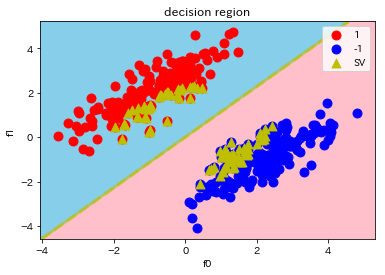

In [107]:
decision_region(X=X_train, y=y_train, model=scratch_svm_poly, step=0.01, title='decision region', xlabel='f0', ylabel='f1', target_names=['1', '-1'])